In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'

NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

 
act_directory = 'C:\\\\Users\\insan\\Documents\\Analysis_Cache'
ops_directory = 'C:\\\\Users\\insan\\Documents\\Opsin_Cache' # use when on pc
beh_directory = 'C:\\\\Users\\insan\\Documents\\Behavioor'
#ops_directory = '/Users/mikeymalina/Data/Insanally/Opsin_Cache' # use when on mac

%run animal_info
ANIMAL = 'AC_12102016'

#animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']


opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179'] # remove BS_191, no postswitch data

dualanimals = ['BS_174','BS_179','BS_191','BS_192']
retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminateopsinanimals = ['BS_139','BS_165','BS_191','BS_192']

didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualrecanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108'] # ,'DS_15','DS_19', 'BS_50'

## Loading and processing cells for Opsin Data

In [3]:
animals_in_cache = []
for session in tqdm(os.listdir(ops_directory)):
    if 'DS' in session:
            continue
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(ops_directory)):
    if 'DS' in session:
            continue
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)

100%|██████████| 97/97 [00:00<00:00, 125.83it/s]


In [4]:
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_174','BS_179']
animalnames = np.concatenate([opsinanimalnames])

animals_opsin = dict()
for animal in animalnames:
    animals_opsin[animal] = SimpleNamespace()
    animals_opsin[animal].name = animal
    
#Opsin Animals
animals_opsin['BS_86'].reversal = 14
animals_opsin['BS_92'].reversal = 9
animals_opsin['BS_100'].reversal = 11
animals_opsin['BS_103'].reversal = 8
animals_opsin['BS_111'].reversal = 8
animals_opsin['BS_119'].reversal = 10
animals_opsin['BS_123'].reversal = 9
animals_opsin['BS_128'].reversal = 6
animals_opsin['BS_131'].reversal = 14
animals_opsin['BS_139'].reversal = 10
animals_opsin['BS_163'].reversal = 13
animals_opsin['BS_174'].reversal = 14
animals_opsin['BS_179'].reversal = 16


In [5]:
filename = os.path.join('C:\\\\Users\\insan\\Documents\\DataForJMTTotal.csv') # use when in lab
csv = pd.read_csv(filename)
csv

,Day,Percent correct BS_33,d' BS_33,Percent correct BS_40,d' BS_40,Percent correct BS_41,d' BS_41,Percent correct BS_42,d' BS_42,Percent correct BS_49,...,Percent correct BS_179,d' BS_179,Percent correct BS_191,d' BS_191,Percent correct BS_192,d' BS_192,Percent correct BS_213,d' BS_213,Percent correct BS_214,d' BS_214
0,1,49.000000,-0.094000,49.966667,0.038333,59.000000,0.516000,52.500000,0.085000,52.350000,...,49.566667,-0.026667,45.500000,-0.45600,53.000000,0.199000,54.8000,0.1697,56.700,0.2100
1,2,51.000000,0.039000,51.850000,0.121500,55.375000,0.385500,54.625000,0.262250,57.950000,...,49.700000,-0.020000,54.300000,0.33700,54.050000,0.010500,46.6333,-0.1110,52.000,0.0836
2,3,55.000000,0.490000,56.300000,0.350000,68.375000,1.450500,68.166667,1.220000,56.200000,...,51.566667,0.146667,56.825000,0.52475,53.550000,0.120000,53.0000,0.1820,54.100,0.2390
3,4,50.300000,0.000670,60.600000,0.660000,73.075000,2.012500,72.566667,1.310000,57.700000,...,50.066667,0.076667,61.800000,0.95750,53.550000,0.120000,56.0000,0.5950,52.700,0.1945
4,5,45.700000,-0.338000,52.500000,0.156667,60.000000,1.600000,75.766667,1.456667,48.000000,...,58.500000,0.565000,58.566667,0.74000,56.500000,0.530000,55.8300,0.6220,54.700,0.1910
5,6,49.800000,-0.131000,64.400000,0.730000,77.000000,2.400000,75.400000,1.620000,51.600000,...,53.300000,0.375000,70.650000,1.60500,75.900000,1.510000,71.0000,1.8320,51.250,0.0400
6,7,52.500000,0.214000,55.833333,0.403333,29.800000,-1.077500,51.500000,0.110000,54.000000,...,57.250000,0.445000,67.550000,1.17500,74.000000,1.865000,77.8000,1.5400,53.335,0.1565
7,8,50.700000,0.098700,52.150000,0.150000,35.975000,-0.717500,49.333333,0.003333,54.500000,...,63.666667,0.643333,71.900000,1.64500,53.500000,0.550000,53.5000,0.6070,57.133,NaN
8,9,51.300000,0.056000,51.900000,0.110000,50.800000,-0.098333,50.666667,-0.087333,61.600000,...,60.400000,0.733333,72.450000,1.52500,47.280000,-0.358000,39.0000,-0.7815,NaN,NaN
9,10,50.700000,0.090000,65.650000,0.875000,51.566667,-0.043333,57.333333,0.639000,60.200000,...,61.400000,0.522500,70.500000,2.09000,42.450000,-0.391500,49.9250,-0.2475,NaN,NaN


In [6]:
#####
# loading in the data, defining reversal days, define late learning threshold for pre and post
# determine which sessions belong to which phase of learning for each session/animal
#####

def session_learning_phase_opsin():
    
    global animals_opsin
    #filename = os.path.join('/Users','mikeymalina','Data', 'Insanally','DataForJMTTotal.csv') # use when on mac
    filename = os.path.join('C:\\\\Users\\insan\\Documents\\DataForJMTTotal.csv') # use when in lab
    csv = pd.read_csv(filename)

    postthresholds = dict()
    prethresholds = dict()
    prereversaldays = dict()
    postreversaldays = dict()
    prereversaldps = dict()
    postreversaldps = dict()
    premiddlecutoffs = dict()
    postmiddlecutoffs = dict()

    for animalidx,animal in enumerate(animals_opsin):
        print(animal)

        condname = 'd\' ' + animal
        pc_condname = 'Percent correct ' + animal
        days = np.array(list(csv['Day']))
        cond = csv[condname]
        cond_pc = csv[pc_condname]

        #Correct for double reversal days
        for idx,day in enumerate(days):
            if day > animals_opsin[animal].reversal:
                days[idx] = day-1

        prereversaldays = []
        prereversaldps = []
        maxreversaldp = -np.Inf
        minreversaldp = np.Inf
        postreversaldays = []
        postreversaldps = []

        for idx,day in enumerate(days):
            if day < animals_opsin[animal].reversal or np.isnan(animals_opsin[animal].reversal):
                prereversaldays.append(day)
                prereversaldps.append(cond[idx])
            if day == animals_opsin[animal].reversal:
                maxreversaldp = max(cond[idx],maxreversaldp)
                minreversaldp = min(cond[idx],minreversaldp)
            if day > animals_opsin[animal].reversal and not np.isnan(cond[idx]):
                postreversaldays.append(day)
                postreversaldps.append(cond[idx])
                    
       # print(animal)
       # print('days: ',days)
       # print('prereversaldays: ', prereversaldays)
       # print('reversal: ', animals_opsin[animal].reversal)
       # print('postreversaldays: ', postreversaldays)

        ## Prereversal threshold
        maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
        minperf = np.nanmin(prereversaldps)
        prethreshold = minperf + 0.4*(maxperf-minperf)
        prethresholds[animal] = prethreshold
        ##

        ## Postreversal threshold
        try:
            maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
            minperf = np.nanmin(postreversaldps)
        except:
            print(animal+' has no post-reversal')
            maxperf = np.nan
            minperf = np.nan
        postthreshold = minperf + 0.4*(maxperf-minperf)
        postthresholds[animal] = postthreshold
        ##

        ## add thresholds to animals_opsin dict
        animals_opsin[animal].postthreshold = postthresholds[animal]
        animals_opsin[animal].prethreshold = prethresholds[animal]
        ##

        ## defining pre/post days/dps for all animals_opsin
        animals_opsin[animal].prereversaldays = np.array(prereversaldays)
        animals_opsin[animal].prereversaldps = np.array(prereversaldps)
        animals_opsin[animal].postreversaldays = np.array(postreversaldays)
        animals_opsin[animal].postreversaldps = np.array(postreversaldps)
        ##

        #### defining early/middle/late for pre and post
        ## determining preswitch_early learning stages [will need to update to account for sparseness]
        animals_opsin[animal].preswitch_early_days_bool = (animals_opsin[animal].prereversaldps < animals_opsin[animal].prethreshold)
        animals_opsin[animal].preswitch_early_days_idx = np.where(animals_opsin[animal].prereversaldps < animals_opsin[animal].prethreshold)[0]

        animals_opsin[animal].preswitch_expert_days_bool = (animals_opsin[animal].prereversaldps > 1.5)
        animals_opsin[animal].preswitch_expert_days_idx = np.where(animals_opsin[animal].prereversaldps > 1.5)[0]
       
        
        # MM just added this 2/18, not sure why it was missing or if something is wrong
        animals_opsin[animal].postswitch_early_days_bool = (animals_opsin[animal].postreversaldps < animals_opsin[animal].postthreshold)
        animals_opsin[animal].postswitch_early_days_idx = np.where(animals_opsin[animal].postreversaldps < animals_opsin[animal].postthreshold)[0]

        animals_opsin[animal].postswitch_expert_days_bool = (animals_opsin[animal].postreversaldps > 1.5)
        animals_opsin[animal].postswitch_expert_days_idx = np.where(animals_opsin[animal].postreversaldps > 1.5)[0]

        

        # account for instance where there are no expert days
        if len(animals_opsin[animal].preswitch_expert_days_bool) > 0:
            animals_opsin[animal].preswitch_late_days_bool = (~animals_opsin[animal].preswitch_early_days_bool & ~animals_opsin[animal].preswitch_expert_days_bool)
            animals_opsin[animal].preswitch_late_days_idx = np.where(~animals_opsin[animal].preswitch_early_days_bool & ~animals_opsin[animal].preswitch_expert_days_bool)[0]

        if len(animals_opsin[animal].preswitch_expert_days_bool) == 0:
            animals_opsin[animal].preswitch_late_days_bool =(~animals_opsin[animal].preswitch_early_days_bool)
            animals_opsin[animal].preswitch_late_days_idx = np.where(~animals_opsin[animal].preswitch_early_days_bool)[0]
            
            
        if len(animals_opsin[animal].postswitch_expert_days_bool) > 0:
            animals_opsin[animal].postswitch_late_days_bool = (~animals_opsin[animal].postswitch_early_days_bool & ~animals_opsin[animal].postswitch_expert_days_bool)
            animals_opsin[animal].postswitch_late_days_idx = np.where(~animals_opsin[animal].postswitch_early_days_bool & ~animals_opsin[animal].postswitch_expert_days_bool)[0]

        if len(animals_opsin[animal].postswitch_expert_days_bool) == 0:
            animals_opsin[animal].postswitch_late_days_bool =(~animals_opsin[animal].postswitch_early_days_bool)
            animals_opsin[animal].postswitch_late_days_idx = np.where(~animals_opsin[animal].postswitch_early_days_bool)[0]
        ##
              

        ###### cleaning up learning phases to shift days after late/expert that are sub-threshold to be late/expert
        ## pre
        if len(animals_opsin[animal].preswitch_expert_days_idx) > 0:

            preS_expert_range = np.arange(np.min(animals_opsin[animal].preswitch_expert_days_idx), animals_opsin[animal].reversal -1) # removed -1 here, check back 

            # and if there are late days
            if len(animals_opsin[animal].preswitch_late_days_idx) > 0:
                preS_late_range = np.arange(np.min(animals_opsin[animal].preswitch_late_days_idx), np.min(preS_expert_range)) 
                preS_early_range = np.arange(0, np.min(preS_late_range))

            # or if there are no late days
            if len(animals_opsin[animal].preswitch_late_days_idx) == 0:
                preS_late_range = []
                preS_early_range = np.arange(0, np.min(preS_expert_range)) 

        # if there are not expert days
        if len(animals_opsin[animal].preswitch_expert_days_idx) == 0:
            preS_expert_range = [] 

            # and there are late days 
            if len(animals_opsin[animal].preswitch_late_days_idx) > 0:
                preS_late_range = np.arange(np.min(animals_opsin[animal].preswitch_late_days_idx), animals_opsin[animal].reversal)
                preS_early_range = np.arange(0, np.min(preS_late_range))

            # or if there are no late days
            if len(animals_opsin[animal].preswitch_late_days_idx) == 0:
                preS_late_range = []
                preS_early_range = np.arange(0, animals_opsin[animal].reversal)                                      
        
        # make proper indices for all this
        animals_opsin[animal].preS_early_range_sessionNum = preS_early_range 
        animals_opsin[animal].preS_late_range_sessionNum = preS_late_range 
        animals_opsin[animal].preS_expert_range_sessionNum = preS_expert_range # below will make them indexable with session # in sessionfiles
        ####
        

        # postswitch cases   
        ###### cleaning up learning phases to shift days after late/expert that are sub-threshold to be late/expert
        ## post
        postreversaldays_idx = animals_opsin[animal].postreversaldays - animals_opsin[animal].reversal - 1 # defining the length of postreversaldays starting from 0
        #print('postreversaldays')

        if len(animals_opsin[animal].postswitch_expert_days_idx) > 0:
                                                                                                                                # COME BACK HERE !!!!!!!!!!!
            postS_expert_range = np.arange(np.min(animals_opsin[animal].postswitch_expert_days_idx), np.max(postreversaldays_idx)+1) # may need to add plus 1 to np.max here 

            # and if there are late days
            # BS_179 has a weird instance, has a late day but it is after first expert day. doesnt work w code flow
            if animal == 'BS_179':
                animals_opsin[animal].postswitch_late_days_idx = []
            if len(animals_opsin[animal].postswitch_late_days_idx) > 0:
                # BS_103 is weird
                if animal == 'BS_103':
                    postS_expert_range = [7]
                    postS_late_range = np.arange(np.min(animals_opsin[animal].postswitch_late_days_idx), np.min(postS_expert_range)) 
                    postS_early_range = np.arange(0, np.min(postS_late_range)) 
                if animal != 'BS_103':
                    postS_late_range = np.arange(np.min(animals_opsin[animal].postswitch_late_days_idx), np.min(postS_expert_range))
                    postS_early_range = np.arange(0, np.min(postS_late_range)) 

            # or if there are no late days
            if len(animals_opsin[animal].postswitch_late_days_idx) == 0:
                postS_late_range = []
                postS_early_range = np.arange(0, np.min(postS_expert_range)) 

        # if there are not expert days
        if len(animals_opsin[animal].postswitch_expert_days_idx) == 0:
            postS_expert_range = [] 

            # and there are late days 
            if len(animals_opsin[animal].postswitch_late_days_idx) > 0: 
                postS_late_range = np.arange(np.min(animals_opsin[animal].postswitch_late_days_idx), np.max(postreversaldays_idx)+1)
                postS_early_range = np.arange(0, np.min(postS_late_range))

            # or if there are no late days
            if len(animals_opsin[animal].postswitch_late_days_idx) == 0:
                postS_late_range = []
                postS_early_range = np.arange(0, np.max(postreversaldays_idx)+1)  

        if animal == 'BS_86':
            postS_early_range = postS_late_range
            postS_late_range = []

            # make proper indices for all this
            animals_opsin[animal].postS_early_range = postS_late_range 
            animals_opsin[animal].postS_late_range = postS_early_range 
            animals_opsin[animal].postS_expert_range = postS_expert_range 
            ######
            #######     

        # make proper indices for all this
        animals_opsin[animal].postS_early_range = postS_early_range 
        animals_opsin[animal].postS_late_range = postS_late_range 
        animals_opsin[animal].postS_expert_range = postS_expert_range  

        if len(animals_opsin[animal].postS_early_range) > 0:                                                                  ## removing + 1 below, maybe put back
            animals_opsin[animal].postS_early_range_sessionNum = animals_opsin[animal].postS_early_range + animals_opsin[animal].reversal 
        if len(animals_opsin[animal].postS_early_range) == 0:
            animals_opsin[animal].postS_early_range_sessionNum = []
        if len(animals_opsin[animal].postS_late_range) > 0:
            animals_opsin[animal].postS_late_range_sessionNum = animals_opsin[animal].postS_late_range + animals_opsin[animal].reversal 
        if len(animals_opsin[animal].postS_late_range) == 0:
            animals_opsin[animal].postS_late_range_sessionNum = []
                
            
        # again, BS_103 is weird, something ab only one postS_expert day is throwing it off. this fixes it. whatever.
        if len(animals_opsin[animal].postS_expert_range) > 0:
            if animal == 'BS_103':
                animals_opsin[animal].postS_expert_range_sessionNum = [7 +  animals_opsin[animal].reversal]
            else:
                animals_opsin[animal].postS_expert_range_sessionNum = animals_opsin[animal].postS_expert_range + animals_opsin[animal].reversal ## removing +1, if i die this is why
        if len(animals_opsin[animal].postS_expert_range) == 0:
            animals_opsin[animal].postS_expert_range_sessionNum = []

        animals_opsin[animal].postS_early_range = postS_early_range 
        animals_opsin[animal].postS_late_range = postS_late_range 
        animals_opsin[animal].postS_expert_range = postS_expert_range # below will make them indexable with session # in sessionfiles
        ####
                


In [7]:
session_learning_phase_opsin()

BS_86
BS_92
BS_100
BS_103
BS_111
BS_119
BS_123
BS_128
BS_131
BS_139
BS_163
BS_174
BS_179


In [9]:
print(animals_opsin['BS_179'].postS_early_range)


[0 1 2 3]


## Loading and processing cells for Dual Rec Data

In [10]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

firstExpert.pre['BS_61'] = 7
firstExpert.post['BS_61'] = 18

In [11]:
def find_active_trials(outcomes,window_length = 75, active_thresholds = [0.2,0.8], verification_threshold = 0.8):
    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    
    gos = np.logical_or(hits,falarms)
    participation = np.array([np.mean(gos[i:(i+window_length)]) for i in range(len(gos)-window_length)])
    
    #Calculate where active conditions are fulfilled
    activehighthresh = np.less(participation,active_thresholds[1])
    activelowthresh = np.greater(participation,active_thresholds[0])
    active = np.logical_and(activehighthresh,activelowthresh)
    #Get trial numbers
    activetrials = np.where(active)[0]
    if len(activetrials) >= 2:
        activestart = np.min(activetrials)
        activeend = np.max(activetrials)
    else:
        activestart = np.nan
        activeend = np.nan
    
    ############################################ If there's no active period then skip everything
    if not np.isfinite(activestart) or not np.isfinite(activeend):
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Verify that an appropriate amount of this span is active
    activespan = np.array(range(len(active)))
    tempspan = np.greater_equal(activespan,activestart)
    tempspan2 = np.less_equal(activespan,activeend)
    activespan = np.logical_and(tempspan,tempspan2)
    verification_frac = np.sum(active) / np.sum(activespan)
    #Check against verification_threshold and abort if insufficient
    if np.isfinite(verification_frac) and verification_frac < verification_threshold:
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Now return a proper valid_trials object
    activeend += window_length
    valid_trials = np.zeros_like(outcomes,dtype='bool')
    valid_trials[activestart:activeend] = True
    return valid_trials

In [12]:
def getSessionByTraining(directory,animal,region,day_of_training):
    for session in os.listdir(directory):
        sessionfile = ilep.loadSessionCached(directory,session)
        
        if sessionfile.meta.animal == animal and sessionfile.meta.region == region and sessionfile.meta.day_of_training == day_of_training:
            return sessionfile
        
    return None

In [13]:
def getOutcomesFromSession(sessionfile):
    outcomes = np.full_like(sessionfile.trials.starts,np.nan)
    hits = np.logical_and(sessionfile.trials.go,sessionfile.trials.target)
    misses = np.logical_and(np.logical_not(sessionfile.trials.go),sessionfile.trials.target)
    falarms = np.logical_and(sessionfile.trials.go,np.logical_not(sessionfile.trials.target))
    crejects = np.logical_and(np.logical_not(sessionfile.trials.go),np.logical_not(sessionfile.trials.target))
    outcomes[hits] = 1*np.ones(np.sum(hits))
    outcomes[misses] = 2*np.ones(np.sum(misses))
    outcomes[falarms] = 3*np.ones(np.sum(falarms))
    outcomes[crejects] = 4*np.ones(np.sum(crejects))
    return outcomes

In [14]:
animals_dualrec = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [15]:
def getAnimalBehaviorResults(animal,directory):
    hit_pct_ON = []
    miss_pct_ON = []
    falarm_pct_ON = []
    creject_pct_ON = []
    hit_pct_OFF = []
    miss_pct_OFF = []
    falarm_pct_OFF = []
    creject_pct_OFF = []
    sessionnum_list = np.sort([k for k in animals_dualrec[animal].sessions])

    for sessionnum in sessionnum_list:

        try:
            sessionfile = getSessionByTraining(directory,animal,'AC',sessionnum)
            outcomes_OFF = []
            outcomes_ON = []
            hasON = False
            if sessionfile is None:
                outcomes = animals_dualrec[animal].sessions[sessionnum].outcomes
                if hasattr(animals_dualrec[animal].sessions[sessionnum],'laser'):
                    laser = animals_dualrec[animal].sessions[sessionnum].laser
                else:
                    laser = np.zeros_like(outcomes,dtype='bool')
                
                ##############################################################################################
                valid_trials = find_active_trials(outcomes,window_length=75,verification_threshold=0.6)
                laser_ON = np.logical_and(laser,valid_trials)
                laser_OFF = np.logical_and(np.logical_not(laser),valid_trials)
                ##############################################################################################
                outcomes_ON = outcomes[laser_ON]
                outcomes_OFF = outcomes[laser_OFF]
            else:
                outcomes = getOutcomesFromSession(sessionfile)
                if hasattr(sessionfile.trials,'laser_stimulation'):
                    laser = sessionfile.trials.laser_stimulation
                else:
                    laser = np.zeros_like(outcomes,dtype='bool')
                    
                
                ##############################################################################################
                valid_trials = find_active_trials(outcomes,window_length=75,verification_threshold=0.6)
                laser_ON = np.logical_and(laser,valid_trials)
                laser_OFF = np.logical_and(np.logical_not(laser),valid_trials)
                ##############################################################################################
                outcomes_ON = outcomes[laser_ON]
                outcomes_OFF = outcomes[laser_OFF]


            hit_pct_ON.append(np.sum(np.equal(outcomes_ON,1))/len(outcomes_ON))
            miss_pct_ON.append(np.sum(np.equal(outcomes_ON,2))/len(outcomes_ON))
            falarm_pct_ON.append(np.sum(np.equal(outcomes_ON,3))/len(outcomes_ON))
            creject_pct_ON.append(np.sum(np.equal(outcomes_ON,4))/len(outcomes_ON))
            hit_pct_OFF.append(np.sum(np.equal(outcomes_OFF,1))/len(outcomes_OFF))
            miss_pct_OFF.append(np.sum(np.equal(outcomes_OFF,2))/len(outcomes_OFF))
            falarm_pct_OFF.append(np.sum(np.equal(outcomes_OFF,3))/len(outcomes_OFF))
            creject_pct_OFF.append(np.sum(np.equal(outcomes_OFF,4))/len(outcomes_OFF))
        except Exception as e:
            print(e)
            raise e
    corr_pct_ON = [h + c for (h,c) in zip(hit_pct_ON,creject_pct_ON)]
    corr_pct_OFF = [h + c for (h,c) in zip(hit_pct_OFF,creject_pct_OFF)]

    results = SimpleNamespace()
    results.sessionnum_list = np.array(sessionnum_list)
    results.corr_pct_ON = np.array(corr_pct_ON)
    results.hit_pct_ON = np.array(hit_pct_ON)
    results.miss_pct_ON = np.array(miss_pct_ON)
    results.falarm_pct_ON = np.array(falarm_pct_ON)
    results.creject_pct_ON = np.array(creject_pct_ON)
    results.corr_pct_OFF = np.array(corr_pct_OFF)
    results.hit_pct_OFF = np.array(hit_pct_OFF)
    results.miss_pct_OFF = np.array(miss_pct_OFF)
    results.falarm_pct_OFF = np.array(falarm_pct_OFF)
    results.creject_pct_OFF = np.array(creject_pct_OFF)
    return results

In [16]:
# Here computing percents of each trial type for dualRec
dual_pct_corr = []
dual_pct_hit = []
dual_pct_miss = []
dual_pct_falarm = []
dual_pct_creject = []

for animal in dualrecanimalnames:

    results = getAnimalBehaviorResults(animal,act_directory)
    animals_dualrec[animal]. results = results
    
    # adjusting sessionnumlist to reflect reversal day
    for idx,day in enumerate(animals_dualrec[animal].results.sessionnum_list):
        if day > animals_dualrec[animal].reversal:
            animals_dualrec[animal].results.sessionnum_list[idx] = day-1
    
    if not hasattr(animals_dualrec[animal],'reversal'):
        continue
        
    cutoffday = animals_dualrec[animal].reversal + 12
    not_cut_off_days = np.where(np.less_equal(results.sessionnum_list,cutoffday))[0]
    day_to_use = np.max(not_cut_off_days)
    
    if firstExpert.post[animal] < day_to_use:
        day_to_use = firstExpert.post[animal]
    
    postreversal_days = day_to_use#np.greater(results.sessionnum_list,animalBehaviors[animal].reversal)
    dual_pct_hit.append(results.hit_pct_OFF[postreversal_days])
    dual_pct_miss.append(results.miss_pct_OFF[postreversal_days])
    dual_pct_falarm.append(results.falarm_pct_OFF[postreversal_days])
    dual_pct_creject.append(results.creject_pct_OFF[postreversal_days])
    dual_pct_corr.append(results.corr_pct_OFF[postreversal_days])
    print(animal, 'done')

BS_40 done
BS_41 done
BS_42 done
BS_49 done
BS_51 done
BS_56 done
BS_59 done
BS_61 done
BS_67 done
BS_70 done
BS_72 done
BS_87 done
BS_108 done


In [19]:
# this will parse out sessions for dual rec animals into pre/post early/late/expert
def session_learning_phase_dualrec(animal):

    # prespecifying size of arrays by # of days pre and post reversal, needs to be float to preserve decimal values
    animals_dualrec[animal].prereversaldays = np.arange(1,animals_dualrec[animal].reversal)  # 1 indexing days 
    animals_dualrec[animal].postreversaldays = np.arange(animals_dualrec[animal].reversal+1, np.max(animals_dualrec[animal].results.sessionnum_list)+1) # 1 indexing days 
    animals_dualrec[animal].prereversaldps = np.float_(np.arange(1,animals_dualrec[animal].reversal))
    animals_dualrec[animal].postreversaldps = np.float_(np.arange(animals_dualrec[animal].reversal+1, np.max(animals_dualrec[animal].results.sessionnum_list)+1))

    numSessionsMax = np.max(animals_dualrec[animal].results.sessionnum_list)

    pre = 0
    post = 0
    for i in np.arange(1,numSessionsMax+1):

        # compiling all pre dps across sessions
        if i < animals_dualrec[animal].reversal:
            animals_dualrec[animal].prereversaldps[pre] = animals_dualrec[animal].sessions[i].pre_dp_sessions
            pre = pre + 1

        # compiling all post dps across sessions
        if i > animals_dualrec[animal].reversal:
            animals_dualrec[animal].postreversaldps[post] = animals_dualrec[animal].sessions[i].post_dp_sessions
            post = post + 1

    # computing pre and post expert thresholds from min and max values         
    animals_dualrec[animal].prethreshold = np.min(animals_dualrec[animal].prereversaldps) + 0.4 * (np.max(animals_dualrec[animal].prereversaldps) - np.min(animals_dualrec[animal].prereversaldps))
    animals_dualrec[animal].postthreshold = np.min(animals_dualrec[animal].postreversaldps) + 0.4 * (np.max(animals_dualrec[animal].postreversaldps) - np.min(animals_dualrec[animal].postreversaldps))

    # computing pre and post switch early and expert
    animals_dualrec[animal].preswitch_early_days_bool = (animals_dualrec[animal].prereversaldps < animals_dualrec[animal].prethreshold)
    animals_dualrec[animal].preswitch_early_days_idx = np.where(animals_dualrec[animal].prereversaldps < animals_dualrec[animal].prethreshold)[0]

    animals_dualrec[animal].preswitch_expert_days_bool = (animals_dualrec[animal].prereversaldps > 1.5)
    animals_dualrec[animal].preswitch_expert_days_idx = np.where(animals_dualrec[animal].prereversaldps > 1.5)[0]
                                                                                                                                            # adding reversal day here to align with sessions[x]
                                                                                                                                            # plus one since sessions is 1-indexed
    animals_dualrec[animal].postswitch_early_days_bool = (animals_dualrec[animal].postreversaldps < animals_dualrec[animal].postthreshold) + animals_dualrec[animal].reversal + 1
    animals_dualrec[animal].postswitch_early_days_idx = np.where(animals_dualrec[animal].postreversaldps < animals_dualrec[animal].postthreshold)[0] + animals_dualrec[animal].reversal + 1

    animals_dualrec[animal].postswitch_expert_days_bool = (animals_dualrec[animal].postreversaldps > 1.5) + animals_dualrec[animal].reversal + 1
    animals_dualrec[animal].postswitch_expert_days_idx = np.where(animals_dualrec[animal].postreversaldps > 1.5)[0] + animals_dualrec[animal].reversal + 1
    
    # account for instance where there are no expert days to compute late days
    if len(animals_dualrec[animal].preswitch_expert_days_bool) > 0:
        animals_dualrec[animal].preswitch_late_days_bool = (~animals_dualrec[animal].preswitch_early_days_bool & ~animals_dualrec[animal].preswitch_expert_days_bool) 
        animals_dualrec[animal].preswitch_late_days_idx = np.where(~animals_dualrec[animal].preswitch_early_days_bool & ~animals_dualrec[animal].preswitch_expert_days_bool)[0]

    if len(animals_dualrec[animal].preswitch_expert_days_bool) == 0:
        animals_dualrec[animal].preswitch_late_days_bool =(~animals_dualrec[animal].preswitch_early_days_bool)
        animals_dualrec[animal].preswitch_late_days_idx = np.where(~animals_dualrec[animal].preswitch_early_days_bool)[0]


    if len(animals_dualrec[animal].postswitch_expert_days_bool) > 0:                                             # concatenating early and expert and set diff from postreversaldays to retrieve late days
        animals_dualrec[animal].postswitch_late_days_idx = np.setdiff1d(animals_dualrec[animal].postreversaldays, np.concatenate([list(animals_dualrec[animal].postswitch_early_days_idx), list(animals_dualrec[animal].postswitch_expert_days_idx)]))

    if len(animals_dualrec[animal].postswitch_expert_days_bool) == 0:
        animals_dualrec[animal].postswitch_late_days_idx = np.setdiff1d(animals_dualrec[animal].postreversaldays, animals_dualrec[animal].postswitch_early_days_idx)

    ###### cleaning up learning phases to shift days after late/expert that are sub-threshold to be late/expert
    ## PRESWITCH
    if len(animals_dualrec[animal].preswitch_expert_days_idx) > 0:

        preS_expert_range = np.arange(np.min(animals_dualrec[animal].preswitch_expert_days_idx), animals_dualrec[animal].reversal -1) # removed -1 here, check back 

        # and if there are late days
        if len(animals_dualrec[animal].preswitch_late_days_idx) > 0:
            
            # if there are more than one late days
            if len(animals_dualrec[animal].preswitch_late_days_idx) > 1:
                preS_late_range = np.arange(np.min(animals_dualrec[animal].preswitch_late_days_idx), np.min(preS_expert_range)) 
                preS_early_range = np.arange(1, np.min(preS_late_range))

            # if there is only one late day
            if len(animals_dualrec[animal].preswitch_late_days_idx) == 1:
                preS_late_range = animals_dualrec[animal].preswitch_late_days_idx
                preS_early_range = np.arange(1, preS_late_range)

        # or if there are no late days
        if len(animals_dualrec[animal].preswitch_late_days_idx) == 0:
            preS_late_range = []
            preS_early_range = np.arange(1, np.min(preS_expert_range)) 

    # if there are not expert days
    if len(animals_dualrec[animal].preswitch_expert_days_idx) == 0:
        preS_expert_range = [] 

        # and there are late days 
        if len(animals_dualrec[animal].preswitch_late_days_idx) > 0:
            preS_late_range = np.arange(np.min(animals_dualrec[animal].preswitch_late_days_idx), animals_dualrec[animal].reversal)
            preS_early_range = np.arange(1, np.min(preS_late_range))

        # or if there are no late days
        if len(animals_dualrec[animal].preswitch_late_days_idx) == 0:
            preS_late_range = []
            preS_early_range = np.arange(1, animals_dualrec[animal].reversal) 


    # make proper indices for all this
    animals_dualrec[animal].preS_early_range_sessionNum = preS_early_range 
    animals_dualrec[animal].preS_late_range_sessionNum = preS_late_range 
    animals_dualrec[animal].preS_expert_range_sessionNum = preS_expert_range # below will make them indexable with session # in sessionfiles
    ####

    ###############
    ## POSTSWITCH
    
    #if there are expert days
    if len(animals_dualrec[animal].postswitch_expert_days_idx) > 0:
                                                                                                         
        postS_expert_range = np.arange(np.min(animals_dualrec[animal].postswitch_expert_days_idx), np.max(animals_dualrec[animal].postreversaldays)+1) # may need to add plus 1 to np.max here 

        # and if there are late days
        if len(animals_dualrec[animal].postswitch_late_days_idx) > 0:

            # this if statement accounts for situations where there is only one late day
            if len(animals_dualrec[animal].postswitch_late_days_idx) > 1:

                postS_late_range = np.arange(np.min(animals_dualrec[animal].postswitch_late_days_idx), np.min(postS_expert_range))
                postS_early_range = np.arange(np.min(animals_dualrec[animal].postswitch_early_days_idx), np.min(np.min(animals_dualrec[animal].postswitch_late_days_idx)))
           
            if len(animals_dualrec[animal].postswitch_late_days_idx) == 1:
                postS_late_range = animals_dualrec[animal].postswitch_late_days_idx
                postS_early_range =  np.arange(np.min(animals_dualrec[animal].postswitch_late_days_idx), postS_late_range)
       
        # or if there are no late days    
        if len(animals_dualrec[animal].postswitch_late_days_idx) == 0:
            postS_late_range = []
            postS_early_range = np.arange(np.min(animals_dualrec[animal].postreversaldays), np.min(postS_expert_range))
    
    # if there are not expert days
    if len(animals_dualrec[animal].postswitch_expert_days_idx) == 0:
        postS_expert_range = [] 

        # and there are late days 
        if len(animals_dualrec[animal].postswitch_late_days_idx) > 0:
            postS_late_range = np.arange(np.min(animals_dualrec[animal].postswitch_late_days_idx), np.max(animals_dualrec[animal].postreversaldays)+1)
            postS_early_range = np.arange(np.min(animals_dualrec[animal].postswitch_early_days_idx), np.min(postS_late_range))

        # or if there are no late days
        if len(animals_dualrec[animal].postswitch_late_days_idx) == 0:
            postS_late_range = []
            postS_early_range = np.arange(animals_dualrec[animal].reversal + 1, np.max(postreversaldays_idx)+1)

    # make proper indices for all this
    animals_dualrec[animal].postS_early_range_sessionNum = postS_early_range 
    animals_dualrec[animal].postS_late_range_sessionNum = postS_late_range 
    animals_dualrec[animal].postS_expert_range_sessionNum = postS_expert_range  

    # just printing things
    print('------------------------------------------------------------------------')
    print(animal)
    print('reversal:',animals_dualrec[animal].reversal)
    print('postreversaldays:',animals_dualrec[animal].postreversaldays)
    print('postthreshold:',animals_dualrec[animal].postthreshold)
    print('postreversaldps:',animals_dualrec[animal].postreversaldps)
    print('-------------')
    print('postS_early_range:', animals_dualrec[animal].postS_early_range_sessionNum)
    print('postS_late_range:', animals_dualrec[animal].postS_late_range_sessionNum)
    print('postS_expert_range:', animals_dualrec[animal].postS_expert_range_sessionNum)


In [20]:
for animal in dualrecanimalnames:
    session_learning_phase_dualrec(animal)

------------------------------------------------------------------------
BS_40
reversal: 18
postreversaldays: [19 20 21 22 23 24 25 26 27 28 29 30 31]
postthreshold: -0.09006616647556998
postreversaldps: [-1.13769046 -0.45311307  0.13745682 -0.37065788  0.02926309 -0.24535934
  0.04247074  0.16989167  0.95079662  0.21190464  0.22735428  1.21646362
  1.48137027]
-------------
postS_early_range: [19 20]
postS_late_range: [21 22 23 24 25 26 27 28 29 30 31]
postS_expert_range: []
------------------------------------------------------------------------
BS_41
reversal: 6
postreversaldays: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
postthreshold: 0.5850457159552135
postreversaldps: [-0.80075493 -0.09842112 -0.14895188  0.09151906  0.11246662  0.16706538
  0.00620643  0.55597566  0.64441639  1.74930068  1.66929287  0.80869462
  1.90128372  2.2548397   2.66374668]
-------------
postS_early_range: [ 7  8  9 10 11 12 13 14]
postS_late_range: [15]
postS_expert_range: [16 17 18 19 20 21]
------

In [ ]:
# function will compute behavioral performance across different stages of learning
def compute_behavior_arrays_dualrec(animal): 
    
    early_array = np.zeros((40,5))
    late_array = np.zeros((40,5))
    expert_array = np.zeros((40,5))
    #if animal != 'BS_40':
    #    continue
    
    # so I know how many sessions are in each stage per animal
    early_num = 0
    late_num = 0
    expert_num = 0

    results = getAnimalBehaviorResults(animal,act_directory)
    for i in results.sessionnum_list:
        
        # dont care abot prereversal right now
        if i not in animals_dualrec[animal].postreversaldays:
            continue

        if animals_dualrec[animal].sessions[i].type == 'postreversal':
            allTrials = np.sum([animals_dualrec[animal].sessions[i].offPostBehavior.hits, animals_dualrec[animal].sessions[i].offPostBehavior.misses, animals_dualrec[animal].sessions[i].offPostBehavior.falarms, animals_dualrec[animal].sessions[i].offPostBehavior.crejects])
            hitTrials = animals_dualrec[animal].sessions[i].offPostBehavior.hits / allTrials
            missTrials = animals_dualrec[animal].sessions[i].offPostBehavior.misses / allTrials
            crejectTrials = animals_dualrec[animal].sessions[i].offPostBehavior.crejects / allTrials
            falarmTrials = animals_dualrec[animal].sessions[i].offPostBehavior.falarms / allTrials
            corrTrials = (hitTrials + crejectTrials) / allTrials
        
        if i in animals_dualrec[animal].postS_early_range_sessionNum:
            early_array[early_num][0] = corrTrials
            early_array[early_num][1] = hitTrials
            early_array[early_num][2] = missTrials
            early_array[early_num][3] = crejectTrials
            early_array[early_num][4] = falarmTrials
            early_num = early_num + 1
           
        if i in animals_dualrec[animal].postS_late_range_sessionNum:
            late_array[late_num][0] = corrTrials
            late_array[late_num][1] = hitTrials
            late_array[late_num][2] = missTrials
            late_array[late_num][3] = crejectTrials
            late_array[late_num][4] = falarmTrials        
            late_num = late_num + 1

        if i in animals_dualrec[animal].postS_expert_range_sessionNum:
            expert_array[expert_num][0] = corrTrials
            expert_array[expert_num][1] = hitTrials
            expert_array[expert_num][2] = missTrials
            expert_array[expert_num][3] = crejectTrials
            expert_array[expert_num][4] = falarmTrials        
            expert_num = expert_num + 1
    
    # clean up beh arrays and save to animals_dualrec
    early_array = early_array[~np.all(early_array == 0, axis=1)]
    late_array = late_array[~np.all(late_array == 0, axis=1)]
    expert_array = expert_array[~np.all(expert_array == 0, axis=1)]
    animals_dualrec[animal].early_array = early_array
    animals_dualrec[animal].late_array = late_array
    animals_dualrec[animal].expert_array = expert_array
    animals_dualrec[animal].early_num = early_num
    animals_dualrec[animal].late_num = late_num
    animals_dualrec[animal].expert_num = expert_num
    print(animal, ' done')

In [25]:
for animal in dualrecanimalnames:
    compute_behavior_arrays_dualrec(animal)

BS_40  done
BS_41  done
BS_42  done
BS_49  done
BS_51  done
BS_56  done
BS_59  done
BS_61  done
BS_67  done
BS_70  done
BS_72  done
BS_87  done
BS_108  done


In [125]:
## compute means and SEMs for behavior arrays produced above
# check back on SEMs when get to plotting

for animal in dualrecanimalnames:
    
    animals_dualrec[animal].postS_early_array_mean = []
    animals_dualrec[animal].postS_late_array_mean = []
    animals_dualrec[animal].postS_expert_array_mean = []
    
    animals_dualrec[animal].postS_early_array_SEMhi = []
    animals_dualrec[animal].postS_late_array_SEMhi = []
    animals_dualrec[animal].postS_expert_array_SEMhi = []
    
    animals_dualrec[animal].postS_early_array_SEMlo = []
    animals_dualrec[animal].postS_late_array_SEMlo = []
    animals_dualrec[animal].postS_expert_array_SEMlo = []
    
    animals_dualrec[animal].postS_early_array_mean = np.multiply(np.mean(animals_dualrec[animal].early_array, axis = 0), 100)
    animals_dualrec[animal].postS_late_array_mean = np.multiply(np.mean(animals_dualrec[animal].late_array, axis = 0), 100)
    animals_dualrec[animal].postS_expert_array_mean = np.multiply(np.mean(animals_dualrec[animal].expert_array, axis = 0), 100)
    
    animals_dualrec[animal].postS_early_array_SEMhi = animals_dualrec[animal].early_array_mean + np.multiply(sem(animals_dualrec[animal].early_array, axis=0),100)
    animals_dualrec[animal].postS_early_array_SEMlo = animals_dualrec[animal].early_array_mean - np.multiply(sem(animals_dualrec[animal].early_array, axis=0),100)
    
    animals_dualrec[animal].postS_late_array_SEMhi = animals_dualrec[animal].late_array_mean + np.multiply(sem(animals_dualrec[animal].late_array, axis=0),100)
    animals_dualrec[animal].postS_late_array_SEMlo = animals_dualrec[animal].late_array_mean - np.multiply(sem(animals_dualrec[animal].late_array, axis=0),100)
    
    animals_dualrec[animal].postS_expert_array_SEMhi = animals_dualrec[animal].expert_array_mean + np.multiply(sem(animals_dualrec[animal].expert_array, axis=0),100)
    animals_dualrec[animal].postS_expert_array_SEMlo = animals_dualrec[animal].expert_array_mean - np.multiply(sem(animals_dualrec[animal].expert_array, axis=0),100)


In [36]:
animal = 'BS_40'
print(animals_dualrec[animal].early_array)
print(animals_dualrec[animal].early_array_mean)

print(animals_dualrec[animal].early_array_SEMhi)
print(animals_dualrec[animal].early_array_SEMlo)


[[0.0013     0.37333333 0.13666667 0.01666667 0.47333333]
 [0.00152222 0.41666667 0.09       0.04       0.45333333]]
[ 0.14111111 39.5        11.33333333  2.83333333 46.33333333]
[ 0.15222222 41.66666667 13.66666667  4.         47.33333333]
[ 0.13       37.33333333  9.          1.66666667 45.33333333]


In [26]:
## Checkign to makre sure everything looks good with breaking down into learning phases
# opsin animals should be zero indexed
# dual rec animals should be indexed from day of reversal

print('For Opsin Animals:')
for animal in didnotlearnopsinanimals:
    print('--------------')
    print(animal)
    print('postS_early:',animals_opsin[animal].postS_early_range_sessionNum)
    print('postS_late:',animals_opsin[animal].postS_late_range_sessionNum)
    print('postS_expert:',animals_opsin[animal].postS_expert_range_sessionNum)
print('----------------------------------------------------------')
print('For DualRec Animals:')
for animal in dualrecanimalnames:
    print('--------------')   
    print(animal)
    print('reversal:',animals_dualrec[animal].reversal)
    print('postS_early:',animals_dualrec[animal].postS_early_range_sessionNum)
    print('postS_late:',animals_dualrec[animal].postS_late_range_sessionNum)
    print('postS_expert:',animals_dualrec[animal].postS_expert_range_sessionNum)


For Opsin Animals:
--------------
BS_86
postS_early: [14 15 16 17 18 19 20 21 22 23 24 25 26]
postS_late: []
postS_expert: []
--------------
BS_100
postS_early: [11 12 13 14 15 16 17 18 19 20 21]
postS_late: [22 23 24 25]
postS_expert: []
--------------
BS_119
postS_early: [10 11 12 13 14 15 16 17 18 19 20]
postS_late: []
postS_expert: []
--------------
BS_123
postS_early: [ 9 10 11 12 13 14 15 16 17 18 19]
postS_late: [20]
postS_expert: []
--------------
BS_128
postS_early: [6 7 8]
postS_late: [ 9 10 11 12 13 14 15]
postS_expert: []
--------------
BS_131
postS_early: [14 15 16 17 18 19 20 21]
postS_late: [22 23 24]
postS_expert: []
--------------
BS_163
postS_early: [13 14 15 16 17 18]
postS_late: []
postS_expert: []
--------------
BS_174
postS_early: [14 15 16 17 18 19 20 21 22]
postS_late: [23 24]
postS_expert: [25 26]
----------------------------------------------------------
For DualRec Animals:
--------------
BS_40
reversal: 18
postS_early: [19 20]
postS_late: [21 22 23 24 25 26 

## Functions to process and plot data for Opsin and DualRec animals

In [13]:
def view_learning_phases(animal):

    print('preS_early_range_sessionNum: ', animals[animal].preS_early_range_sessionNum)
    print('preS_late_range_sessionNum: ', animals[animal].preS_late_range_sessionNum)
    print('preS_expert_range_sessionNum: ', animals[animal].preS_expert_range_sessionNum)
    print('reversal (0 indexed): ', animals[animal].reversal - 1)
    print('postS_early_range_sessionNum: ', animals[animal].postS_early_range_sessionNum)
    print('postS_late_range_sessionNum: ', animals[animal].postS_late_range_sessionNum)
    print('postS_expert_range_sessionNum: ', animals[animal].postS_expert_range_sessionNum)

In [33]:
# will compute sessions belonging to each learning stage
session_learning_phase_opsin()
view_learning_phases('BS_86')

BS_191 has no post-reversal
preS_early_range_sessionNum:  [0 1 2 3 4 5]
preS_late_range_sessionNum:  [ 6  7  8  9 10]
preS_expert_range_sessionNum:  [11 12]
reversal (0 indexed):  13
postS_early_range_sessionNum:  [14 15 16 17 18 19 20 21 22 23 24 25 26]
postS_late_range_sessionNum:  []
postS_expert_range_sessionNum:  []


In [194]:
# pre-defining how large arrays should be 
def define_session_arrays(animals):
    
    for animalidx,animal in enumerate(opsinanimalnames):
    
        # defining amount of sessions relevant for each animal       
        animals_opsin[animal].postS_early_array_laserON = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 5))
        animals_opsin[animal].postS_late_array_laserON = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 5))
        animals_opsin[animal].postS_expert_array_laserON = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 5))
        animals_opsin[animal].postS_early_array_laserOFF = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 5))
        animals_opsin[animal].postS_late_array_laserOFF = np.zeros((len(animals_opsin[animal].postS_late_range_sessionNum), 5))
        animals_opsin[animal].postS_expert_array_laserOFF = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 5))
        
    for animalidx,animal in enumerate(dualrecanimalnames):
        
        animals_dualrec[animal].postS_early_array_laserOFF = np.zeros((len(animals_dualrec[animal].postS_early_range), 5))
        animals_dualrec[animal].postS_late_array_laserOFF = np.zeros((len(animals_dualrec[animal].postS_late_range), 5))
        animals_dualrec[animal].postS_expert_array_laserOFF = np.zeros((len(animals_dualrec[animal].postS_early_range), 5))
                                            

In [195]:
# will compute # of sessions per animal per learning stage and set up empty arrays
define_session_arrays(animals)

In [37]:
def behavior_performance_opsin(ops_directory, animal):

    for session in tqdm(os.listdir(ops_directory)):

        if 'DS' in session:
            continue
        
        sessionfile = ilep.loadSessionCached(ops_directory,session)

        if sessionfile.meta.animal != animal:
            continue

        animal = sessionfile.meta.animal
        session = sessionfile.meta.day_of_training - 1 # aligning with zero index

        ## extract behavioral information and separate across laserON and laserOFF trials
        # grab laser trials
        laserON_trials_bool = sessionfile.trials.laser_stimulation
        laserOFF_trials_bool = ~sessionfile.trials.laser_stimulation
        laserON_trials_idx = np.where(sessionfile.trials.laser_stimulation)[0]
        laserOFF_trials_idx = np.where(~sessionfile.trials.laser_stimulation)[0]

        # combine behavioral outcomes and laser
        CR_trials_laserON_bool = ~sessionfile.trials.go & sessionfile.trials.correct & sessionfile.trials.laser_stimulation
        CR_trials_laserOFF_bool = ~sessionfile.trials.go & sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        FA_trials_laserON_bool = sessionfile.trials.go & ~sessionfile.trials.correct & sessionfile.trials.laser_stimulation
        FA_trials_laserOFF_bool = sessionfile.trials.go & ~sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        hit_trials_laserON_bool = sessionfile.trials.go & sessionfile.trials.correct & sessionfile.trials.laser_stimulation
        hit_trials_laserOFF_bool = sessionfile.trials.go & sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        miss_trials_laserON_bool = ~sessionfile.trials.go & ~sessionfile.trials.correct & sessionfile.trials.laser_stimulation
        miss_trials_laserOFF_bool = ~sessionfile.trials.go & ~sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        CR_trials_laserON_idx = np.where(CR_trials_laserON_bool)[0]
        CR_trials_laserOFF_idx = np.where(CR_trials_laserOFF_bool)[0]
        FA_trials_laserON_idx = np.where(FA_trials_laserON_bool)[0]
        FA_trials_laserOFF_idx = np.where(FA_trials_laserOFF_bool)[0]
        hit_trials_laserON_idx = np.where(hit_trials_laserON_bool)[0]
        hit_trials_laserOFF_idx = np.where(hit_trials_laserOFF_bool)[0]
        miss_trials_laserON_idx = np.where(miss_trials_laserON_bool)[0]
        miss_trials_laserOFF_idx = np.where(miss_trials_laserOFF_bool)[0]
        ##

        ## compute percentages of events
        num_trials_all = len(sessionfile.trials.starts)
        num_laserON_trials = len(laserON_trials_idx)
        num_laserOFF_trials = len(laserOFF_trials_idx)

        num_CR_laserON_trials = len(CR_trials_laserON_idx); CR_laserON_trials_percent = num_CR_laserON_trials / num_laserON_trials
        num_CR_laserOFF_trials = len(CR_trials_laserOFF_idx); CR_laserOFF_trials_percent = num_CR_laserOFF_trials / num_laserOFF_trials
        num_FA_laserON_trials = len(FA_trials_laserON_idx); FA_laserON_trials_percent = num_FA_laserON_trials / num_laserON_trials
        num_FA_laserOFF_trials = len(FA_trials_laserOFF_idx); FA_laserOFF_trials_percent = num_FA_laserOFF_trials / num_laserOFF_trials
        num_hit_laserON_trials = len(hit_trials_laserON_idx); hit_laserON_trials_percent = num_hit_laserON_trials / num_laserON_trials
        num_hit_laserOFF_trials = len(hit_trials_laserOFF_idx); hit_laserOFF_trials_percent = num_hit_laserOFF_trials / num_laserOFF_trials
        num_miss_laserON_trials = len(miss_trials_laserON_idx); miss_laserON_trials_percent = num_miss_laserON_trials / num_laserON_trials
        num_miss_laserOFF_trials = len(miss_trials_laserOFF_idx); miss_laserOFF_trials_percent = num_miss_laserOFF_trials / num_laserOFF_trials
        num_correct_laserON_trials = len(CR_trials_laserON_idx) + len(hit_trials_laserON_idx); correct_laserON_trials_percent = num_correct_laserON_trials / num_laserON_trials
        num_correct_laserOFF_trials = len(CR_trials_laserOFF_idx) + len(hit_trials_laserOFF_idx); correct_laserOFF_trials_percent = num_correct_laserOFF_trials / num_laserOFF_trials

    
        print('session #: ', session)
        print('num_trials_all: ', num_trials_all)
        print('num_laserON_trials: ', num_laserON_trials)
        print('num_laserOFF_trials: ', num_laserOFF_trials)
        print('num_CR_laserON_trials: ', num_CR_laserON_trials)
        print('CR_laserON_trials_percent: ', CR_laserON_trials_percent)
        print('num_CR_laserOFF_trials: ', num_CR_laserOFF_trials)
        print('CR_laserOFF_trials_percent: ', CR_laserOFF_trials_percent)

        print('num_FA_laserON_trials: ', num_FA_laserON_trials)
        print('FA_laserON_trials_percent: ', FA_laserON_trials_percent)

        print('num_FA_laserOFF_trials: ', num_FA_laserOFF_trials)
        print('FA_laserOFF_trials_percent: ', FA_laserOFF_trials_percent)

        print('num_hit_laserON_trials: ', num_hit_laserON_trials)
        print('hit_laserON_trials_percent: ', hit_laserON_trials_percent)

        print('num_hit_laserOFF_trials: ', num_hit_laserOFF_trials)
        print('hit_laserOFF_trials_percent: ', hit_laserOFF_trials_percent)

        print('num_miss_laserON_trials: ', num_miss_laserON_trials)
        print('miss_laserON_trials_percent: ', miss_laserON_trials_percent)


        print('num_miss_laserOFF_trials: ', num_miss_laserOFF_trials)
        print('miss_laserOFF_trials_percent: ', miss_laserOFF_trials_percent)

        print('num_correct_laserON_trials: ', num_correct_laserON_trials)
        print('correct_laserON_trials_percent: ', correct_laserON_trials_percent)

        print('num_correct_laserOFF_trials: ', num_correct_laserOFF_trials)
        print('correct_laserOFF_trials_percent: ', correct_laserOFF_trials_percent)

In [186]:
# GOAL HERE:
# load in session, determine animal and session number
# compute all values for that session (CR, FA, hit, miss, correct trials)
# if session number is within range of preS_early_range_sessionNum, populate
# preS_early_array(i) with the appropriate values, and then add an index so that
# the next session is added in the next slot of the matrix

def compute_behavior_arrays_opsin(ops_directory, animals_opsin, animal_name):
    
    for animalidx,animal in enumerate(animals_opsin):
        if animal != animal_name:
            continue
        
        # defining amount of sessions relevant for each animal by 
        animals_opsin[animal].preS_early_array_laserON = np.zeros((len(animals_opsin[animal].preS_early_range_sessionNum), 6))
        animals_opsin[animal].preS_late_array_laserON = np.zeros((len(animals_opsin[animal].preS_late_range_sessionNum), 6))
        animals_opsin[animal].preS_expert_array_laserON = np.zeros((len(animals_opsin[animal].preS_early_range_sessionNum), 6))
        animals_opsin[animal].preS_early_array_laserOFF = np.zeros((len(animals_opsin[animal].preS_early_range_sessionNum), 6))
        animals_opsin[animal].preS_late_array_laserOFF = np.zeros((len(animals_opsin[animal].preS_late_range_sessionNum), 6))
        animals_opsin[animal].preS_expert_array_laserOFF = np.zeros((len(animals_opsin[animal].preS_early_range_sessionNum), 6))

        animals_opsin[animal].postS_early_array_laserON = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 6))
        animals_opsin[animal].postS_late_array_laserON = np.zeros((len(animals_opsin[animal].postS_late_range_sessionNum), 6))
        animals_opsin[animal].postS_expert_array_laserON = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 6))
        animals_opsin[animal].postS_early_array_laserOFF = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 6))
        animals_opsin[animal].postS_late_array_laserOFF = np.zeros((len(animals_opsin[animal].postS_late_range_sessionNum), 6))
        animals_opsin[animal].postS_expert_array_laserOFF = np.zeros((len(animals_opsin[animal].postS_early_range_sessionNum), 6))
        
    
    # reset indices used below to update indexing
    postS_early_idx = 0
    postS_late_idx = 0
    postS_expert_idx = 0
    for session in tqdm(os.listdir(ops_directory)):

        # only do when on mac
        #if 'DS' in session:
        #    continue
        
        sessionfile = ilep.loadSessionCached(ops_directory,session)
        animal = sessionfile.meta.animal
        
        if animal != animal_name:
            continue 
        
        # define session
        session = sessionfile.meta.day_of_training -1
        
        ## extract behavioral information and separate across laserON and laserOFF trials
        # grab laser trials
        laserON_trials_bool = sessionfile.trials.laser_stimulation
        laserOFF_trials_bool = ~sessionfile.trials.laser_stimulation
        laserON_trials_idx = np.where(sessionfile.trials.laser_stimulation)[0]
        laserOFF_trials_idx = np.where(~sessionfile.trials.laser_stimulation)[0]

        # combine behavioral outcomes and laser
        CR_trials_laserON_bool = ~sessionfile.trials.go & sessionfile.trials.correct & sessionfile.trials.laser_stimulation # correct reject trials do not go and are correct
        CR_trials_laserOFF_bool = ~sessionfile.trials.go & sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        FA_trials_laserON_bool = sessionfile.trials.go & ~sessionfile.trials.correct & sessionfile.trials.laser_stimulation # false alarm trials go and are not correct
        FA_trials_laserOFF_bool = sessionfile.trials.go & ~sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        hit_trials_laserON_bool = sessionfile.trials.go & sessionfile.trials.correct & sessionfile.trials.laser_stimulation # hit trials go and are correct
        hit_trials_laserOFF_bool = sessionfile.trials.go & sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        miss_trials_laserON_bool = ~sessionfile.trials.go & ~sessionfile.trials.correct & sessionfile.trials.laser_stimulation # miss trials do not go and are not correct
        miss_trials_laserOFF_bool = ~sessionfile.trials.go & ~sessionfile.trials.correct & ~sessionfile.trials.laser_stimulation
        CR_trials_laserON_idx = np.where(CR_trials_laserON_bool)[0]
        CR_trials_laserOFF_idx = np.where(CR_trials_laserOFF_bool)[0]
        FA_trials_laserON_idx = np.where(FA_trials_laserON_bool)[0]
        FA_trials_laserOFF_idx = np.where(FA_trials_laserOFF_bool)[0]
        hit_trials_laserON_idx = np.where(hit_trials_laserON_bool)[0]
        hit_trials_laserOFF_idx = np.where(hit_trials_laserOFF_bool)[0]
        miss_trials_laserON_idx = np.where(miss_trials_laserON_bool)[0]
        miss_trials_laserOFF_idx = np.where(miss_trials_laserOFF_bool)[0]
        ##

        ## compute percentages of events
        num_trials_all = len(sessionfile.trials.starts)
        num_laserON_trials = len(laserON_trials_idx)
        num_laserOFF_trials = len(laserOFF_trials_idx)

        num_CR_laserON_trials = len(CR_trials_laserON_idx); CR_laserON_trials_percent = num_CR_laserON_trials / num_laserON_trials
        num_CR_laserOFF_trials = len(CR_trials_laserOFF_idx); CR_laserOFF_trials_percent = num_CR_laserOFF_trials / num_laserOFF_trials
        num_FA_laserON_trials = len(FA_trials_laserON_idx); FA_laserON_trials_percent = num_FA_laserON_trials / num_laserON_trials
        num_FA_laserOFF_trials = len(FA_trials_laserOFF_idx); FA_laserOFF_trials_percent = num_FA_laserOFF_trials / num_laserOFF_trials
        num_hit_laserON_trials = len(hit_trials_laserON_idx); hit_laserON_trials_percent = num_hit_laserON_trials / num_laserON_trials
        num_hit_laserOFF_trials = len(hit_trials_laserOFF_idx); hit_laserOFF_trials_percent = num_hit_laserOFF_trials / num_laserOFF_trials
        num_miss_laserON_trials = len(miss_trials_laserON_idx); miss_laserON_trials_percent = num_miss_laserON_trials / num_laserON_trials
        num_miss_laserOFF_trials = len(miss_trials_laserOFF_idx); miss_laserOFF_trials_percent = num_miss_laserOFF_trials / num_laserOFF_trials
        num_correct_laserON_trials = len(CR_trials_laserON_idx) + len(hit_trials_laserON_idx); correct_laserON_trials_percent = num_correct_laserON_trials / num_laserON_trials
        num_correct_laserOFF_trials = len(CR_trials_laserOFF_idx) + len(hit_trials_laserOFF_idx); correct_laserOFF_trials_percent = num_correct_laserOFF_trials / num_laserOFF_trials

        ## postswitch early
        animals_opsin[animal].postS_early_array_days = []
        if session in animals_opsin[animal].postS_early_range_sessionNum:

            # populate arrays with values for each event
            animals_opsin[animal].postS_early_array_laserON[postS_early_idx,0] = correct_laserON_trials_percent
            animals_opsin[animal].postS_early_array_laserON[postS_early_idx,1] = CR_laserON_trials_percent
            animals_opsin[animal].postS_early_array_laserON[postS_early_idx,2] = FA_laserON_trials_percent
            animals_opsin[animal].postS_early_array_laserON[postS_early_idx,3] = hit_laserON_trials_percent
            animals_opsin[animal].postS_early_array_laserON[postS_early_idx,4] = miss_laserON_trials_percent
            animals_opsin[animal].postS_early_array_laserON[postS_early_idx,5] = session

            animals_opsin[animal].postS_early_array_laserOFF[postS_early_idx,0] = correct_laserOFF_trials_percent
            animals_opsin[animal].postS_early_array_laserOFF[postS_early_idx,1] = CR_laserOFF_trials_percent
            animals_opsin[animal].postS_early_array_laserOFF[postS_early_idx,2] = FA_laserOFF_trials_percent
            animals_opsin[animal].postS_early_array_laserOFF[postS_early_idx,3] = hit_laserOFF_trials_percent
            animals_opsin[animal].postS_early_array_laserOFF[postS_early_idx,4] = miss_laserOFF_trials_percent
            animals_opsin[animal].postS_early_array_laserOFF[postS_early_idx,5] = session

            # update index
            postS_early_idx = postS_early_idx + 1        
            
        ## postswitch late
        if session in animals_opsin[animal].postS_late_range_sessionNum:

            # populate arrays with values for each event 
            animals_opsin[animal].postS_late_array_laserON[postS_late_idx,0] = correct_laserON_trials_percent
            animals_opsin[animal].postS_late_array_laserON[postS_late_idx,1] = CR_laserON_trials_percent
            animals_opsin[animal].postS_late_array_laserON[postS_late_idx,2] = FA_laserON_trials_percent
            animals_opsin[animal].postS_late_array_laserON[postS_late_idx,3] = hit_laserON_trials_percent
            animals_opsin[animal].postS_late_array_laserON[postS_late_idx,4] = miss_laserON_trials_percent
            animals_opsin[animal].postS_late_array_laserON[postS_late_idx,5] = session

            animals_opsin[animal].postS_late_array_laserOFF[postS_late_idx,0] = correct_laserOFF_trials_percent
            animals_opsin[animal].postS_late_array_laserOFF[postS_late_idx,1] = CR_laserOFF_trials_percent
            animals_opsin[animal].postS_late_array_laserOFF[postS_late_idx,2] = FA_laserOFF_trials_percent
            animals_opsin[animal].postS_late_array_laserOFF[postS_late_idx,3] = hit_laserOFF_trials_percent
            animals_opsin[animal].postS_late_array_laserOFF[postS_late_idx,4] = miss_laserOFF_trials_percent
            animals_opsin[animal].postS_late_array_laserOFF[postS_late_idx,5] = session

            # update index
            postS_late_idx = postS_late_idx + 1

        ## postswitch expert 
        if session in animals_opsin[animal].postS_expert_range_sessionNum:

            # populate arrays with values for each event   
            animals_opsin[animal].postS_expert_array_laserON[postS_expert_idx,0] = correct_laserON_trials_percent
            animals_opsin[animal].postS_expert_array_laserON[postS_expert_idx,1] = CR_laserON_trials_percent
            animals_opsin[animal].postS_expert_array_laserON[postS_expert_idx,2] = FA_laserON_trials_percent
            animals_opsin[animal].postS_expert_array_laserON[postS_expert_idx,3] = hit_laserON_trials_percent
            animals_opsin[animal].postS_expert_array_laserON[postS_expert_idx,4] = miss_laserON_trials_percent
            animals_opsin[animal].postS_expert_array_laserON[postS_expert_idx,5] = session

            animals_opsin[animal].postS_expert_array_laserOFF[postS_expert_idx,0] = correct_laserOFF_trials_percent
            animals_opsin[animal].postS_expert_array_laserOFF[postS_expert_idx,1] = CR_laserOFF_trials_percent
            animals_opsin[animal].postS_expert_array_laserOFF[postS_expert_idx,2] = FA_laserOFF_trials_percent
            animals_opsin[animal].postS_expert_array_laserOFF[postS_expert_idx,3] = hit_laserOFF_trials_percent
            animals_opsin[animal].postS_expert_array_laserOFF[postS_expert_idx,4] = miss_laserOFF_trials_percent
            animals_opsin[animal].postS_expert_array_laserOFF[postS_expert_idx,5] = session

            # update index
            postS_expert_idx = postS_expert_idx + 1
                     

In [177]:
print(np.shape(animals_opsin['BS_86'].postS_early_array_laserOFF_means))
animals_dualrec['BS_40'].__dict__.keys()
print(np.shape(animals_dualrec['BS_40'].postS_early_array_mean))

(6,)
(5,)


In [194]:
for animalidx,animal in enumerate(didnotlearnopsinanimals):
    compute_behavior_arrays_opsin(ops_directory, animals_opsin, animal)

#print(animals_opsin['BS_111'].postS_expert_array_laserON)

100%|██████████| 97/97 [00:00<00:00, 167.20it/s]


In [197]:
# this will remove empty rows (from sessions we dont have ephys data for) and produce means
# only care about post switch data here
def clean_up_behavior_arrays_opsin():
    
    for animalidx,animal in enumerate(didnotlearnopsinanimals):

        # remove empty rows, will have empty rows from sessions that are in a certain learning phase but that we don't have ephys data for so aren't analyzing here
        animals_opsin[animal].postS_early_array_laserON = animals_opsin[animal].postS_early_array_laserON[~np.all(animals_opsin[animal].postS_early_array_laserON == 0, axis = 1)]
        animals_opsin[animal].postS_early_array_laserOFF = animals_opsin[animal].postS_early_array_laserOFF[~np.all(animals_opsin[animal].postS_early_array_laserOFF == 0, axis = 1)]

        # remove empty rows
        animals_opsin[animal].postS_late_array_laserON = animals_opsin[animal].postS_late_array_laserON[~np.all(animals_opsin[animal].postS_late_array_laserON == 0, axis = 1)]
        animals_opsin[animal].postS_late_array_laserOFF = animals_opsin[animal].postS_late_array_laserOFF[~np.all(animals_opsin[animal].postS_late_array_laserOFF == 0, axis = 1)]

        # remove empty rows
        animals_opsin[animal].postS_expert_array_laserON = animals_opsin[animal].postS_expert_array_laserON[~np.all(animals_opsin[animal].postS_expert_array_laserON == 0, axis = 1)]
        animals_opsin[animal].postS_expert_array_laserOFF = animals_opsin[animal].postS_expert_array_laserOFF[~np.all(animals_opsin[animal].postS_expert_array_laserOFF == 0, axis = 1)]

        # compute means
        if len(animals_opsin[animal].postS_early_array_laserON) > 0:
            animals_opsin[animal].postS_early_array_laserON_means = np.mean(animals_opsin[animal].postS_early_array_laserON, axis=0)
            animals_opsin[animal].postS_early_array_laserOFF_means = np.mean(animals_opsin[animal].postS_early_array_laserOFF, axis=0)
            animals_opsin[animal].postS_early_array_laserON_stds = np.std(animals_opsin[animal].postS_early_array_laserON, axis=0)
            animals_opsin[animal].postS_early_array_laserOFF_stds = np.std(animals_opsin[animal].postS_early_array_laserOFF, axis=0)
       
        if len(animals_opsin[animal].postS_early_array_laserON) == 0:
            animals_opsin[animal].postS_early_array_laserON_means = np.zeros((5))
            animals_opsin[animal].postS_early_array_laserOFF_means = np.zeros((5))
            animals_opsin[animal].postS_early_array_laserON_stds = np.zeros((5))
            animals_opsin[animal].postS_early_array_laserOFF_stds = np.zeros((5))

        # compute means
        if len(animals_opsin[animal].postS_late_array_laserON) > 0:
            animals_opsin[animal].postS_late_array_laserON_means = np.mean(animals_opsin[animal].postS_late_array_laserON, axis=0)
            animals_opsin[animal].postS_late_array_laserOFF_means = np.mean(animals_opsin[animal].postS_late_array_laserOFF, axis=0)
            animals_opsin[animal].postS_late_array_laserON_stds = np.std(animals_opsin[animal].postS_late_array_laserON, axis=0)
            animals_opsin[animal].postS_late_array_laserOFF_stds = np.std(animals_opsin[animal].postS_late_array_laserOFF, axis=0)
            
        if len(animals_opsin[animal].postS_late_array_laserON) == 0:
            animals_opsin[animal].postS_late_array_laserON_means = np.zeros((5))
            animals_opsin[animal].postS_late_array_laserOFF_means = np.zeros((5))
            animals_opsin[animal].postS_late_array_laserON_stds = np.zeros((5))
            animals_opsin[animal].postS_late_array_laserOFF_stds = np.zeros((5))

        # compute means
        if len(animals_opsin[animal].postS_expert_array_laserON) > 0:
            animals_opsin[animal].postS_expert_array_laserON_means = np.mean(animals_opsin[animal].postS_expert_array_laserON, axis=0)
            animals_opsin[animal].postS_expert_array_laserOFF_means = np.mean(animals_opsin[animal].postS_expert_array_laserOFF, axis=0)
            animals_opsin[animal].postS_expert_array_laserON_stds = np.std(animals_opsin[animal].postS_expert_array_laserON, axis=0)
            animals_opsin[animal].postS_expert_array_laserOFF_stds = np.std(animals_opsin[animal].postS_expert_array_laserOFF, axis=0)

        if len(animals_opsin[animal].postS_expert_array_laserON) == 0:
            animals_opsin[animal].postS_expert_array_laserON_means = np.zeros((5))
            animals_opsin[animal].postS_expert_array_laserOFF_means = np.zeros((5))
            animals_opsin[animal].postS_expert_array_laserON_stds = np.zeros((5))
            animals_opsin[animal].postS_expert_array_laserOFF_stds = np.zeros((5))
            
        # sorting arrays by session #
        animals_opsin[animal].postS_early_array_laserON_sorted = animals_opsin[animal].postS_early_array_laserON[animals_opsin[animal].postS_early_array_laserON[:,5].argsort(),:]
        animals_opsin[animal].postS_late_array_laserON_sorted = animals_opsin[animal].postS_late_array_laserON[animals_opsin[animal].postS_late_array_laserON[:,5].argsort(),:] 
        animals_opsin[animal].postS_expert_array_laserON_sorted = animals_opsin[animal].postS_expert_array_laserON[animals_opsin[animal].postS_expert_array_laserON[:,5].argsort(),:]        

        animals_opsin[animal].postS_early_array_laserOFF_sorted = animals_opsin[animal].postS_early_array_laserOFF[animals_opsin[animal].postS_early_array_laserOFF[:,5].argsort(),:] 
        animals_opsin[animal].postS_late_array_laserOFF_sorted = animals_opsin[animal].postS_late_array_laserOFF[animals_opsin[animal].postS_late_array_laserOFF[:,5].argsort(),:] 
        animals_opsin[animal].postS_expert_array_laserOFF_sorted = animals_opsin[animal].postS_expert_array_laserOFF[animals_opsin[animal].postS_expert_array_laserOFF[:,5].argsort(),:] 

        print(animal)

In [198]:
# run the above functions to parce out behavior by learning stages and then clean up arrays for plotting
clean_up_behavior_arrays_opsin()

BS_86
BS_100
BS_119
BS_123
BS_128
BS_131
BS_163
BS_174


In [201]:
# visual check, make sure things look okay
for animal in didnotlearnopsinanimals:

    print(animal)
    
    print('early_laserON: ',animals_opsin[animal].postS_early_array_laserON)
    print('early_laserOFF: ',animals_opsin[animal].postS_early_array_laserOFF)

    print('late_laserON: ',animals_opsin[animal].postS_late_array_laserON)
    print('late_laserOFF: ',animals_opsin[animal].postS_late_array_laserOFF)

    #print('expert_laserON: ',animals[animal].postS_expert_array_laserON)
    #print('expert_laserOFF: ',animals[animal].postS_expert_array_laserOFF)

    print('early_laserON_means: ',animals_opsin[animal].postS_early_array_laserON_means)
    print('early_laserOFF_means: ',animals_opsin[animal].postS_early_array_laserOFF)

    print('late_laserON_means: ',animals_opsin[animal].postS_late_array_laserON)
    print('late_laserOFF_means: ',animals_opsin[animal].postS_late_array_laserOFF)

    print('expert_laserON_means: ',animals_opsin[animal].postS_expert_array_laserON_means)
    print('expert_laserOFF_means: ',animals_opsin[animal].postS_expert_array_laserOFF_means)


    print('late_laserON_stds: ',animals_opsin[animal].postS_late_array_laserON_stds)
    print('late_laserOFF_stds: ',animals_opsin[animal].postS_late_array_laserOFF_stds)
    print('expert_laserON_stds: ',animals_opsin[animal].postS_expert_array_laserON_stds)
    print('expert_laserOFF_stds: ',animals_opsin[animal].postS_expert_array_laserOFF_stds)

BS_86
early_laserON:  [[ 0.54098361  0.05737705  0.39344262  0.48360656  0.06557377 22.        ]
 [ 0.57875458  0.14285714  0.34798535  0.43589744  0.07326007 23.        ]
 [ 0.54716981  0.14622642  0.3254717   0.4009434   0.12735849 14.        ]
 [ 0.52608696  0.0826087   0.39130435  0.44347826  0.0826087  15.        ]
 [ 0.52662722  0.18343195  0.30769231  0.34319527  0.16568047 16.        ]
 [ 0.55        0.12727273  0.35909091  0.42272727  0.09090909 17.        ]
 [ 0.51196172  0.05263158  0.41626794  0.45933014  0.07177033 18.        ]
 [ 0.56804734  0.15384615  0.32544379  0.41420118  0.10650888 19.        ]
 [ 0.57589286  0.05803571  0.39285714  0.51785714  0.03125    20.        ]
 [ 0.56451613  0.17204301  0.3172043   0.39247312  0.11827957 21.        ]]
early_laserOFF:  [[ 0.51778656  0.1027668   0.40316206  0.41501976  0.07905138 22.        ]
 [ 0.4966443   0.11409396  0.37583893  0.38255034  0.12751678 23.        ]
 [ 0.57281553  0.17961165  0.2961165   0.39320388  0.1310679

In [247]:
# for each animal, first,determine whether it is pre or post (through np.isin(array))
# then make a 5 panel subplot, with % correct large and on top, and then 2x2 panels
# of % CR, FA, hit, miss. For all panels, separate by laser on/off

def plot_behavior_arrays(animal):
    
    didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
    didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174'] 

    import matplotlib.pyplot as plt
    import numpy as np

    # make arrays for plotting
    # correct data
    correct_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[0], animals_opsin[animal].postS_early_array_laserON_means[0]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[0], animals_opsin[animal].postS_late_array_laserON_means[0]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[0], animals_opsin[animal].postS_expert_array_laserON_means[0])),100)
    correct_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[0], animals_opsin[animal].postS_early_array_laserON_stds[0]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[0], animals_opsin[animal].postS_late_array_laserON_stds[0]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[0], animals_opsin[animal].postS_expert_array_laserON_stds[0])),100)
    print(animals_opsin[animal].postS_early_array_laserOFF_means[0])
    # CR data
    CR_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[1], animals_opsin[animal].postS_early_array_laserON_means[1]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[1], animals_opsin[animal].postS_late_array_laserON_means[1]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[1], animals_opsin[animal].postS_expert_array_laserON_means[1])),100)
    CR_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[1], animals_opsin[animal].postS_early_array_laserON_stds[1]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[1], animals_opsin[animal].postS_late_array_laserON_stds[1]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[1], animals_opsin[animal].postS_expert_array_laserON_stds[1])),100)
    
    # FA data
    FA_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[2], animals_opsin[animal].postS_early_array_laserON_means[2]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[2], animals_opsin[animal].postS_late_array_laserON_means[2]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[2], animals_opsin[animal].postS_expert_array_laserON_means[2])),100)
    FA_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[2], animals_opsin[animal].postS_early_array_laserON_stds[2]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[2], animals_opsin[animal].postS_late_array_laserON_stds[2]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[2], animals_opsin[animal].postS_expert_array_laserON_stds[2])),100)

    # hit data
    hit_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[3], animals_opsin[animal].postS_early_array_laserON_means[3]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[3], animals_opsin[animal].postS_late_array_laserON_means[3]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[3], animals_opsin[animal].postS_expert_array_laserON_means[3])),100)
    hit_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[3], animals_opsin[animal].postS_early_array_laserON_stds[3]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[3], animals_opsin[animal].postS_late_array_laserON_stds[3]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[3], animals_opsin[animal].postS_expert_array_laserON_stds[3])),100)

    # miss data
    miss_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[4], animals_opsin[animal].postS_early_array_laserON_means[4]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[4], animals_opsin[animal].postS_late_array_laserON_means[4]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[4], animals_opsin[animal].postS_expert_array_laserON_means[4])),100)
    miss_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[4], animals_opsin[animal].postS_early_array_laserON_stds[4]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[4], animals_opsin[animal].postS_late_array_laserON_stds[4]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[4], animals_opsin[animal].postS_expert_array_laserON_stds[4])),100)

    print(miss_postData_means)
    ##### UPDATING CODE TO MAKE LOOPY HERE
    # creating grid for subplots
    #fig,ax = plt.figure()
    fig,ax = plt.subplots(6,1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
    ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
    ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
    ax[3] = plt.subplot2grid((3, 3), (2, 0))
    ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)

   
    # PLOT 1
    ##### plot correct_post         
    if animal in didlearnopsinanimals:
        fig.suptitle('Post-Reversal, Animal ' + animal + ' (did learn)', x=0.39, y =0.92)
    if animal in didnotlearnopsinanimals:
        fig.suptitle('Post-Reversal, Animal ' + animal + ' (did not learn)', x=0.36, y =0.99)
    dim = len(correct_postData_means)
    w = 0.6
    dimw = w / dim
    x = np.arange(len(correct_postData_means))
    y_means = np.zeros((2,3))

    for i in np.arange(0,6):
        if i == 0:

            ax[i].set_title('Correct Trials');

            y_means[0] = [correct_postData_means[0][0], correct_postData_means[1][0], correct_postData_means[2][0]]
            y_means[1] = [correct_postData_means[0][1], correct_postData_means[1][1], correct_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [correct_postData_stds[0][0], correct_postData_stds[1][0], correct_postData_stds[2][0]]
            y_stds[1] = [correct_postData_stds[0][1], correct_postData_stds[1][1], correct_postData_stds[2][1]]
            
        if i == 1:

            ax[i].set_title('Correct Reject Trials')

            y_means[0] = [CR_postData_means[0][0], CR_postData_means[1][0], CR_postData_means[2][0]]
            y_means[1] = [CR_postData_means[0][1], CR_postData_means[1][1], CR_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [CR_postData_stds[0][0], CR_postData_stds[1][0], CR_postData_stds[2][0]]
            y_stds[1] = [CR_postData_stds[0][1], CR_postData_stds[1][1], CR_postData_stds[2][1]]

        if i == 2:

            ax[i].set_title('False Alarm Trials')

            y_means[0] = [FA_postData_means[0][0], FA_postData_means[1][0], FA_postData_means[2][0]]
            y_means[1] = [FA_postData_means[0][1], FA_postData_means[1][1], FA_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [FA_postData_stds[0][0], FA_postData_stds[1][0], FA_postData_stds[2][0]]
            y_stds[1] = [FA_postData_stds[0][1], FA_postData_stds[1][1], FA_postData_stds[2][1]]

        if i == 3:

            ax[i].set_title('Hit Trials')

            y_means[0] = [hit_postData_means[0][0], hit_postData_means[1][0], hit_postData_means[2][0]]
            y_means[1] = [hit_postData_means[0][1], hit_postData_means[1][1], hit_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [hit_postData_stds[0][0], hit_postData_stds[1][0], hit_postData_stds[2][0]]
            y_stds[1] = [hit_postData_stds[0][1], hit_postData_stds[1][1], hit_postData_stds[2][1]]
                             
        if i == 4:
           
            ax[i].set_title('Miss Trials')

            y_means[0] = [miss_postData_means[0][0], miss_postData_means[1][0], miss_postData_means[2][0]]
            y_means[1] = [miss_postData_means[0][1], miss_postData_means[1][1], miss_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [miss_postData_stds[0][0], miss_postData_stds[1][0], miss_postData_stds[2][0]]
            y_stds[1] = [miss_postData_stds[0][1], miss_postData_stds[1][1], miss_postData_stds[2][1]]

        # adding data
        ax[i].bar(x+0*dimw,y_means[0], dimw,  bottom = 0.00, color = GOOD_GREY, label = 'Laser off')
        ax[i].bar(x+1*dimw,y_means[1], dimw,  bottom = 0.00, color = LASER_COLOR, label = 'Laser on')

        ax[i].errorbar(x+0*dimw,y_means[0],y_stds[0],lw=0,elinewidth=1.5,color='k',zorder=5)
        ax[i].errorbar(x+1*dimw,y_means[1],y_stds[1],lw=0,elinewidth=1.5,color='k',zorder=5)


        # adding session numbers, errors here causing
        ax[i].text(0.09,76, len(animals_opsin[animal].postS_early_array_laserON), color='k')
        ax[i].text(1.09,76, len(animals_opsin[animal].postS_late_array_laserON), color = 'k')
        ax[i].text(2.09,76, len(animals_opsin[animal].postS_expert_array_laserON), color = 'k')
        
        if i == 0:
            print(ax[i].set_xticks(x + dimw / 2) is None)
        
        #### 
        
    # setting axes
    ax[0].set_xticks(x + dimw / 2)
    ax[0].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[0].set_yticks([20,40,60,80])
    ax[1].set_xticks(x + dimw / 2)
    ax[1].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[1].set_yticks([20,40,60,80])
    ax[2].set_xticks(x + dimw / 2)
    ax[2].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[2].set_yticks([20,40,60,80])
    ax[3].set_xticks(x + dimw / 2)
    ax[3].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[3].set_yticks([20,40,60,80])
    ax[4].set_xticks(x + dimw / 2)
    ax[4].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[4].set_yticks([20,40,60,80])

    title = str(animal + ' Opsin Behavior.png')
    plt.tight_layout()
    plt.show
    
 
    
    #plt.savefig(os.path.join('/Users/mikeymalina/Data/Insanally/Opsin Behavior Figs',title),transparent=False,facecolor="white")


0.505565907285565
[[13.45443043  9.33199375]
 [ 0.          0.        ]
 [ 0.          0.        ]]
False


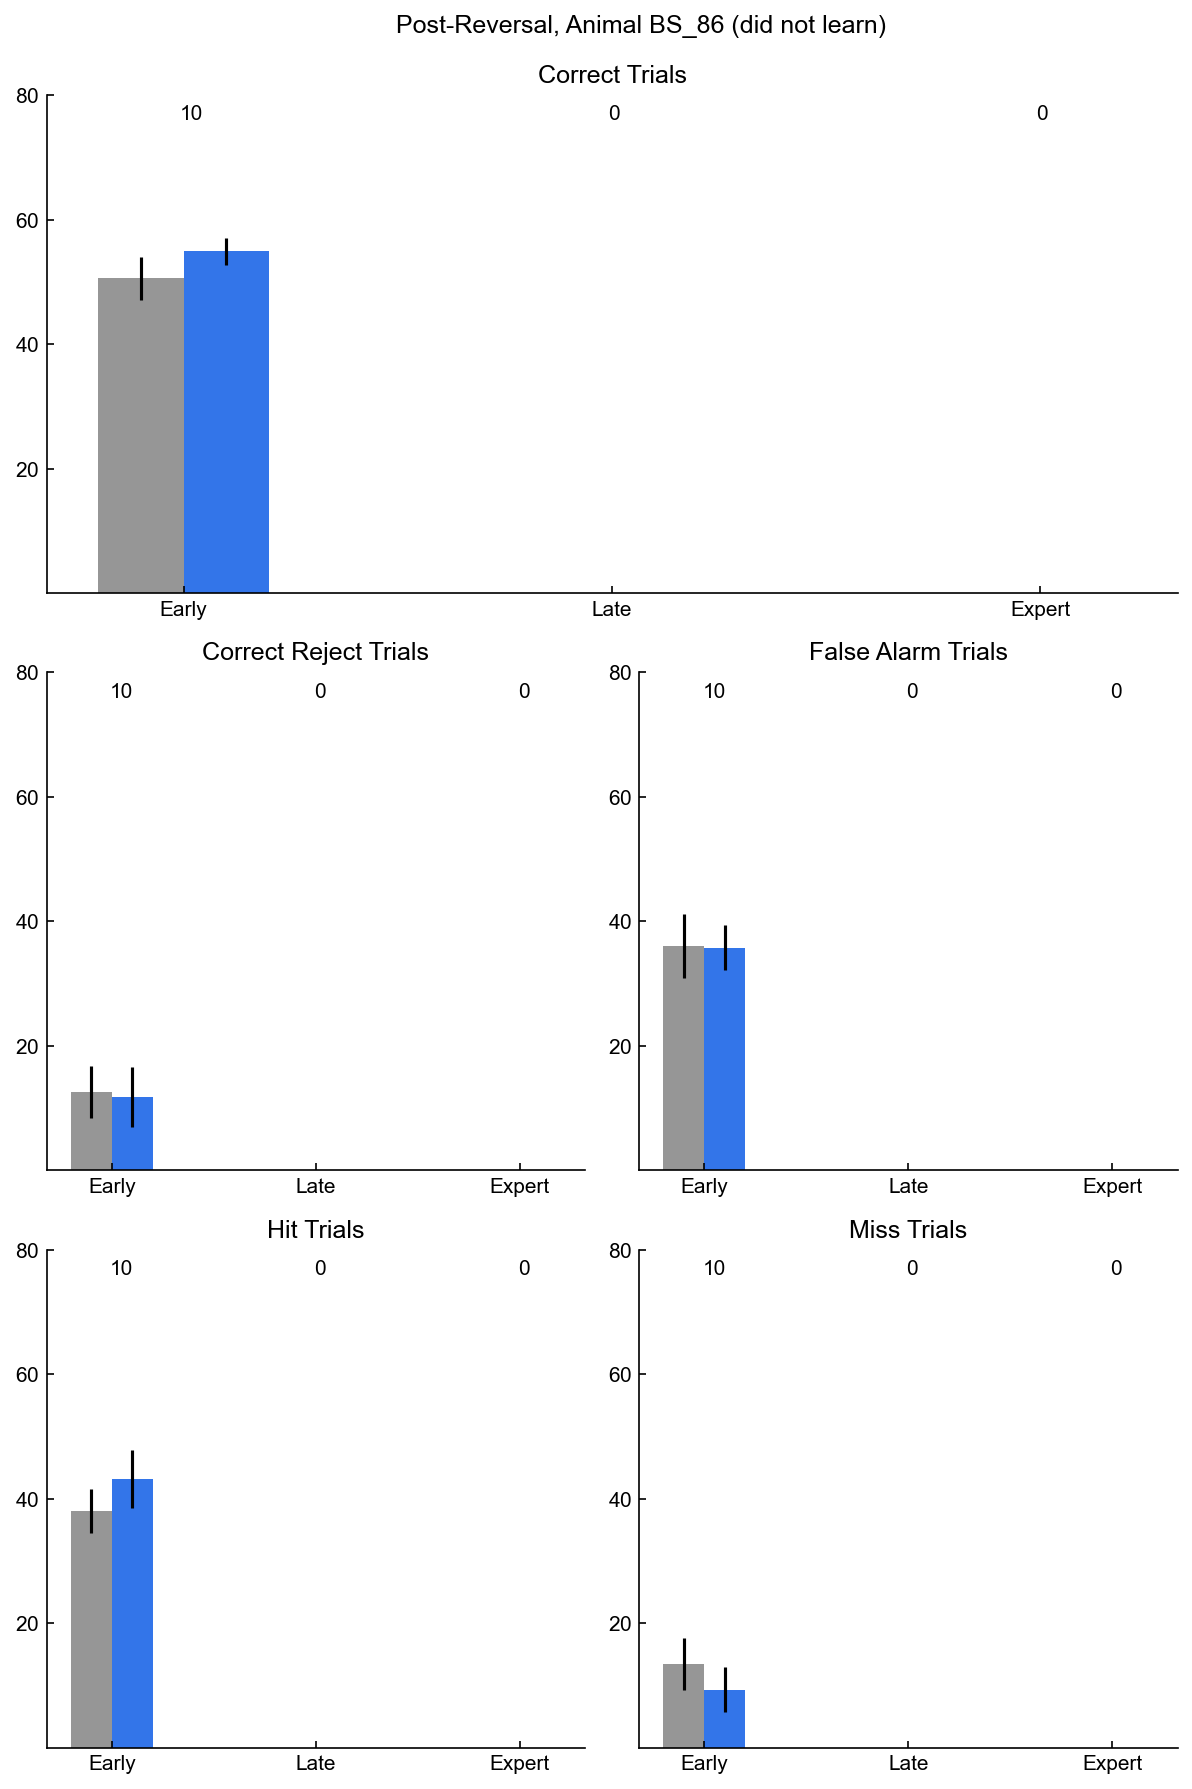

In [248]:
#for animalidx,animal in enumerate(animals):
#    plot_behavior_arrays(animal)
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
plot_behavior_arrays('BS_86')

In [249]:
didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']

result = SimpleNamespace()
def compute_values_learn_dnlearn(didlearnopsinanimals, didnotlearnopsinanimals, animals):
    
    
    
    len_didlearn = len(didlearnopsinanimals)
    len_didnotlearn = len(didnotlearnopsinanimals)

    countdid = 0
    countdidnot = 0

    did_learn_early_laserON = np.zeros((len_didlearn, 5))
    did_learn_early_laserOFF = np.zeros((len_didlearn, 5))

    did_learn_late_laserON = np.zeros((len_didlearn, 5))
    did_learn_late_laserOFF = np.zeros((len_didlearn, 5))

    did_learn_expert_laserON = np.zeros((len_didlearn, 5))
    did_learn_expert_laserOFF = np.zeros((len_didlearn, 5))

    did_not_learn_early_laserON = np.zeros((len_didnotlearn, 5))
    did_not_learn_early_laserOFF = np.zeros((len_didnotlearn, 5))

    did_not_learn_late_laserON = np.zeros((len_didnotlearn, 5))
    did_not_learn_late_laserOFF = np.zeros((len_didnotlearn, 5))

    did_not_learn_expert_laserON = np.zeros((len_didnotlearn, 5))
    did_not_learn_expert_laserOFF = np.zeros((len_didnotlearn, 5))



    did_learn_laserON_stds = np.zeros((len_didlearn, 5))
    did_learn_laserOFF_stds = np.zeros((len_didlearn, 5))

    for animalidx,animal in enumerate(animals_opsin):
        
        if animal in didnotlearnopsinanimals:


            did_not_learn_early_laserON[countdidnot][:] = animals_opsin[animal].postS_early_array_laserON_means
            did_not_learn_early_laserOFF[countdidnot][:] = animals_opsin[animal].postS_early_array_laserOFF_means

            did_not_learn_late_laserON[countdidnot][:] = animals_opsin[animal].postS_late_array_laserON_means
            did_not_learn_late_laserOFF[countdidnot][:] = animals_opsin[animal].postS_late_array_laserOFF_means

            did_not_learn_expert_laserON[countdidnot][:] = animals_opsin[animal].postS_expert_array_laserON_means
            did_not_learn_expert_laserOFF[countdidnot][:] = animals_opsin[animal].postS_expert_array_laserOFF_means

            countdidnot = countdidnot +1

        if animal in didlearnopsinanimals:

            did_learn_early_laserON[countdid][:] = animals_opsin[animal].postS_early_array_laserON_means
            did_learn_early_laserOFF[countdid][:] = animals_opsin[animal].postS_early_array_laserOFF_means

            did_learn_late_laserON[countdid][:] = animals_opsin[animal].postS_late_array_laserON_means
            did_learn_late_laserOFF[countdid][:] = animals_opsin[animal].postS_late_array_laserOFF_means

            did_learn_expert_laserON[countdid][:] = animals_opsin[animal].postS_expert_array_laserON_means
            did_learn_expert_laserOFF[countdid][:] = animals_opsin[animal].postS_expert_array_laserOFF_means

            countdid = countdid +1
    
    # remove 0s and get counts
    did_learn_early_laserON = did_learn_early_laserON[~np.all(did_learn_early_laserON==0, axis=1)]; did_learn_early_laserON_counts = len(did_learn_early_laserON)
    did_learn_late_laserON = did_learn_late_laserON[~np.all(did_learn_late_laserON==0, axis=1)]; did_learn_late_laserON_counts = len(did_learn_late_laserON)
    did_learn_expert_laserON = did_learn_expert_laserON[~np.all(did_learn_expert_laserON==0, axis=1)]; did_learn_expert_laserON_counts = len(did_learn_expert_laserON)
    did_not_learn_early_laserON = did_not_learn_early_laserON[~np.all(did_not_learn_early_laserON==0, axis=1)]; did_not_learn_early_laserON_counts = len(did_not_learn_early_laserON)
    did_not_learn_late_laserON = did_not_learn_late_laserON[~np.all(did_not_learn_late_laserON==0, axis=1)]; did_not_learn_late_laserON_counts = len(did_not_learn_late_laserON)
    did_not_learn_expert_laserON = did_not_learn_expert_laserON[~np.all(did_not_learn_expert_laserON==0, axis=1)]; did_not_learn_expert_laserON_counts = len(did_not_learn_expert_laserON)

    did_learn_early_laserOFF = did_learn_early_laserOFF[~np.all(did_learn_early_laserOFF==0, axis=1)]; did_learn_early_laserOFF_counts = len(did_learn_early_laserOFF)
    did_learn_late_laserOFF = did_learn_late_laserOFF[~np.all(did_learn_late_laserOFF==0, axis=1)]; did_learn_late_laserOFF_counts = len(did_learn_late_laserOFF)
    did_learn_expert_laserOFF = did_learn_expert_laserOFF[~np.all(did_learn_expert_laserOFF==0, axis=1)]; did_learn_expert_laserOFF_counts = len(did_learn_expert_laserOFF)
    did_not_learn_early_laserOFF = did_not_learn_early_laserOFF[~np.all(did_not_learn_early_laserOFF==0, axis=1)]; did_not_learn_early_laserOFF_counts = len(did_not_learn_early_laserOFF)
    did_not_learn_late_laserOFF = did_not_learn_late_laserOFF[~np.all(did_not_learn_late_laserOFF==0, axis=1)]; did_not_learn_late_laserOFF_counts = len(did_not_learn_late_laserOFF)
    did_not_learn_expert_laserOFF = did_not_learn_expert_laserOFF[~np.all(did_not_learn_expert_laserOFF==0, axis=1)]; did_not_learn_expert_laserOFF_counts = len(did_not_learn_expert_laserOFF)

    print('did learn early on counts: ', did_learn_early_laserON_counts)
    print('did learn late on counts: ', did_learn_late_laserON_counts)
    print('did learn expert on counts: ', did_learn_expert_laserON_counts)
    print('did not learn early off counts: ', did_not_learn_early_laserON_counts)
    print('did not learn late off counts: ', did_not_learn_late_laserON_counts)
    print('did not learn expert off counts: ', did_not_learn_expert_laserON_counts)
    did_learn_counts = [did_learn_early_laserON_counts, did_learn_late_laserON_counts, did_learn_expert_laserON_counts]
    did_not_learn_counts = [did_not_learn_early_laserON_counts, did_not_learn_late_laserON_counts, did_not_learn_expert_laserON_counts]



    
    # mean
    did_learn_early_laserON_means = np.mean(did_learn_early_laserON, axis=0)   
    did_learn_late_laserON_means = np.mean(did_learn_late_laserON, axis=0)     
    did_learn_expert_laserON_means = np.mean(did_learn_expert_laserON, axis=0)  

    did_learn_early_laserOFF_means = np.mean(did_learn_early_laserOFF, axis=0)   
    did_learn_late_laserOFF_means = np.mean(did_learn_late_laserOFF, axis=0)     
    did_learn_expert_laserOFF_means = np.mean(did_learn_expert_laserOFF, axis=0) 

    did_not_learn_early_laserON_means = np.mean(did_not_learn_early_laserON, axis=0)   
    did_not_learn_late_laserON_means = np.mean(did_not_learn_late_laserON, axis=0)     
    did_not_learn_expert_laserON_means = np.mean(did_not_learn_expert_laserON, axis=0) 

    did_not_learn_early_laserOFF_means = np.mean(did_not_learn_early_laserOFF, axis=0)   
    did_not_learn_late_laserOFF_means = np.mean(did_not_learn_late_laserOFF, axis=0)     
    did_not_learn_expert_laserOFF_means = np.mean(did_not_learn_expert_laserOFF, axis=0) 

    # std
    did_learn_early_laserON_stds = np.std(did_learn_early_laserON, axis=0)   
    did_learn_late_laserON_stds = np.std(did_learn_late_laserON, axis=0)     
    did_learn_expert_laserON_stds = np.std(did_learn_expert_laserON, axis=0)  

    did_learn_early_laserOFF_stds = np.std(did_learn_early_laserOFF, axis=0)   
    did_learn_late_laserOFF_stds = np.std(did_learn_late_laserOFF, axis=0)     
    did_learn_expert_laserOFF_stds = np.std(did_learn_expert_laserOFF, axis=0) 

    did_not_learn_early_laserON_stds = np.std(did_not_learn_early_laserON, axis=0)   
    did_not_learn_late_laserON_stds = np.std(did_not_learn_late_laserON, axis=0)     
    did_not_learn_expert_laserON_stds = np.std(did_not_learn_expert_laserON, axis=0) 

    did_not_learn_early_laserOFF_stds = np.std(did_not_learn_early_laserOFF, axis=0)   
    did_not_learn_late_laserOFF_stds = np.std(did_not_learn_late_laserOFF, axis=0)     
    did_not_learn_expert_laserOFF_stds = np.std(did_not_learn_expert_laserOFF, axis=0)
    
    ## combine into arrays
    ########
    did_learn_laserON = np.zeros((3,5))
    did_learn_laserON[0][:] = did_learn_early_laserON_means
    did_learn_laserON[1][:] = did_learn_late_laserON_means
    did_learn_laserON[2][:] = did_learn_expert_laserON_means; did_learn_laserON = np.multiply(did_learn_laserON, 100)

    did_learn_laserOFF = np.zeros((3,5))
    did_learn_laserOFF[0][:] = did_learn_early_laserOFF_means
    did_learn_laserOFF[1][:] = did_learn_late_laserOFF_means
    did_learn_laserOFF[2][:] = did_learn_expert_laserOFF_means; did_learn_laserOFF = np.multiply(did_learn_laserOFF, 100)

    did_learn_laserON_stds = np.zeros((3,5))
    did_learn_laserON_stds[0][:] = did_learn_early_laserON_stds
    did_learn_laserON_stds[1][:] = did_learn_late_laserON_stds
    did_learn_laserON_stds[2][:] = did_learn_expert_laserON_stds; did_learn_laserON_stds = np.multiply(did_learn_laserON_stds, 100)

    did_learn_laserOFF_stds = np.zeros((3,5))
    did_learn_laserOFF_stds[0][:] = did_learn_early_laserOFF_stds
    did_learn_laserOFF_stds[1][:] = did_learn_late_laserOFF_stds
    did_learn_laserOFF_stds[2][:] = did_learn_expert_laserOFF_stds; did_learn_laserOFF_stds = np.multiply(did_learn_laserOFF_stds, 100)
        
    did_learn_laserON_counts = np.zeros((3,0))
    did_learn_laserON_counts[0][:] = did_learn_early_laserON_counts
    did_learn_laserON_counts[1][:] = did_learn_late_laserON_counts
    did_learn_laserON_counts[2][:] = did_learn_late_laserON_counts
    
    did_learn_laserOFF_counts = np.zeros((3,0))
    did_learn_laserOFF_counts[0][:] = did_learn_early_laserOFF_counts
    did_learn_laserOFF_counts[1][:] = did_learn_late_laserOFF_counts
    did_learn_laserOFF_counts[2][:] = did_learn_late_laserOFF_counts


    #########

    ########
    did_not_learn_laserON = np.zeros((3,5))
    did_not_learn_laserON[0][:] = did_not_learn_early_laserON_means
    did_not_learn_laserON[1][:] = did_not_learn_late_laserON_means
    did_not_learn_laserON[2][:] = did_not_learn_expert_laserON_means; did_not_learn_laserON = np.multiply(did_not_learn_laserON, 100)

    did_not_learn_laserOFF = np.zeros((3,5))
    did_not_learn_laserOFF[0][:] = did_not_learn_early_laserOFF_means
    did_not_learn_laserOFF[1][:] = did_not_learn_late_laserOFF_means
    did_not_learn_laserOFF[2][:] = did_not_learn_expert_laserOFF_means; did_not_learn_laserOFF = np.multiply(did_not_learn_laserOFF, 100)

    did_not_learn_laserON_stds = np.zeros((3,5))
    did_not_learn_laserON_stds[0][:] = did_not_learn_early_laserON_stds
    did_not_learn_laserON_stds[1][:] = did_not_learn_late_laserON_stds
    did_not_learn_laserON_stds[2][:] = did_not_learn_expert_laserON_stds; did_not_learn_laserON_stds = np.multiply(did_not_learn_laserON_stds, 100)

    did_not_learn_laserOFF_stds = np.zeros((3,5))
    did_not_learn_laserOFF_stds[0][:] = did_not_learn_early_laserOFF_stds
    did_not_learn_laserOFF_stds[1][:] = did_not_learn_late_laserOFF_stds
    did_not_learn_laserOFF_stds[2][:] = did_not_learn_expert_laserOFF_stds; did_not_learn_laserOFF_stds = np.multiply(did_not_learn_laserOFF_stds, 100)
    
    did_not_learn_laserON_counts = np.zeros((3,0))
    did_not_learn_laserON_counts[0][:] = did_not_learn_early_laserON_counts
    did_not_learn_laserON_counts[1][:] = did_not_learn_late_laserON_counts
    did_not_learn_laserON_counts[2][:] = did_not_learn_late_laserON_counts
    
    did_not_learn_laserOFF_counts = np.zeros((3,0))
    did_not_learn_laserOFF_counts[0][:] = did_not_learn_early_laserOFF_counts
    did_not_learn_laserOFF_counts[1][:] = did_not_learn_late_laserOFF_counts
    did_not_learn_laserOFF_counts[2][:] = did_not_learn_late_laserOFF_counts
    
    #########
    result.did_learn_laserON = did_learn_laserON
    result.did_learn_laserOFF = did_learn_laserOFF
    result.did_not_learn_laserON = did_not_learn_laserON
    result.did_not_learn_laserOFF = did_not_learn_laserOFF
    
    result.did_learn_laserON_stds = did_learn_laserON_stds
    result.did_learn_laserOFF_stds = did_learn_laserOFF_stds
    result.did_not_learn_laserON_stds = did_not_learn_laserON_stds
    result.did_not_learn_laserOFF_stds = did_not_learn_laserOFF_stds
    
    result.did_learn_laserON_counts = did_learn_counts
    result.did_not_learn_laserON_counts = did_not_learn_counts
    
    return result


    #learn_dnlearn_values = compute_values_......()
    #learn_dnlearn_values.did_learn_laserON

In [250]:
# will compute means and stds for combined animals broken up by learn and did not learn
compute_values_learn_dnlearn(didlearnopsinanimals, didnotlearnopsinanimals, animals_opsin)



ValueError: could not broadcast input array from shape (6,) into shape (5,)

In [114]:
def plot_this(result, animalType):
    
    if animalType == 'did learn':
        data_off = result.did_learn_laserOFF
        data_on = result.did_learn_laserON
        data_off_stds = result.did_learn_laserOFF_stds
        data_on_stds = result.did_learn_laserON_stds
        data_on_counts = result.did_learn_laserON_counts
        
    if animalType == 'did not learn':
        data_off = result.did_not_learn_laserOFF
        data_on = result.did_not_learn_laserON
        data_off_stds = result.did_not_learn_laserOFF_stds
        data_on_stds = result.did_not_learn_laserON_stds
        data_on_counts = result.did_not_learn_laserON_counts
    
    # PLOT 1
    ##### plot correct_post 
    fig,ax = plt.subplots(figsize=(6,5))
    title = str('Correct Trials, postswitch, ' + animalType + ' animals')
    plt.title(title)
    dim = len(data_off[0])
    w = 0.6
    dimw = w / dim

    x = np.arange(len(data_off))
    y_means = np.zeros((2,3))   
    y_means[0] = [data_off[0][4], data_off[1][4], data_off[2][4]]
    y_means[1] = [data_on[0][4], data_on[1][4], data_on[2][4]]

    y_stds = np.zeros((2,3))   
    y_stds[0] = [data_off_stds[0][4], data_off_stds[1][4], data_off_stds[2][4]]
    y_stds[1] = [data_on_stds[0][4], data_on_stds[1][4], data_on_stds[2][4]]

    # adding data
    ax.bar(x+0*dimw,y_means[0], dimw,  bottom = 0.00, color = GOOD_GREY, label = 'Laser off')
    ax.bar(x+1*dimw,y_means[1], dimw,  bottom = 0.00, color = LASER_COLOR, label = 'Laser on')

    ax.errorbar(x+0*dimw,y_means[0],y_stds[0],lw=0,elinewidth=1.5,color='k',zorder=5)
    ax.errorbar(x+1*dimw,y_means[1],y_stds[1],lw=0,elinewidth=1.5,color='k',zorder=5)

    # setting axes
    ax.set_xticks(x + dimw / 2)
    ax.set_yticks([20,40,60,80])
    ax.set_xticklabels(['Early', 'Late', 'Expert'])
    ax.set_ylabel('Percent of all trials')
    ax.set_xlabel('Learning Phase')
    plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

    # determining largest bar graph for session num placement
    y_height_0 = np.max(data_off)

    # adding session numbers
    ax.text(0.09,76, data_on_counts[0], color='k')
    ax.text(1.09,76, data_on_counts[1], color = 'k')
    ax.text(2.09,76, data_on_counts[2], color = 'k')
    ####  
    #title = str' Opsin Behavior.png')
    #plt.savefig(os.path.join('/Users/mikeymalina/Data/Insanally/Opsin Behavior Figs',title),transparent=False,facecolor="white")
    
    
     # PLOT 2
    ######
    # plot 4 outcome types in a 2,2 subplot  
    fig = plt.figure(figsize=(6,6))
    gs = fig.add_gridspec(2,2,wspace=0.4, hspace=0.4)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,0])
    ax4 = plt.subplot(gs[1,1])
    ######
    
    # plot CR_post 
    #fig,ax = plt.subplots(figsize=(6,5))
    dim = len(data_off[0])
    w = 0.6
    dimw = w / dim

    x = np.arange(len(data_off))
    y_means = np.zeros((2,3))   
    y_means[0] = [data_off[0][0], data_off[1][0], data_off[2][0]]
    y_means[1] = [data_on[0][0], data_on[1][0], data_on[2][0]]

    y_stds = np.zeros((2,3))   
    y_stds[0] = [data_off_stds[0][0], data_off_stds[1][0], data_off_stds[2][0]]
    y_stds[1] = [data_on_stds[0][0], data_on_stds[1][0], data_on_stds[2][0]]

    # adding data
    ax1.bar(x+0*dimw,y_means[0], dimw,  bottom = 0.00, color = GOOD_GREY, label = 'Laser off')
    ax1.bar(x+1*dimw,y_means[1], dimw,  bottom = 0.00, color = LASER_COLOR, label = 'Laser on')

    ax1.errorbar(x+0*dimw,y_means[0],y_stds[0],lw=0,elinewidth=1.5,color='k',zorder=5)
    ax1.errorbar(x+1*dimw,y_means[1],y_stds[1],lw=0,elinewidth=1.5,color='k',zorder=5)

    # setting axes
    ax1.set_xticks(x + dimw / 2)
    ax1.set_yticks([20,40,60,80])
    ax1.set_xticklabels(['Early', 'Late', 'Expert'])

    # determining largest bar graph for session num placement
    y_height_0 = np.max(data_off)

    # adding session numbers
   # ax1.text(0.09,76, data_off_counts[0], color='k')
   # ax1.text(1.09,76, data_off_counts[1], color = 'k')
   # ax1.text(2.09,76, data_off_counts[2], color = 'k')
    
    title_str = ('Correct Reject trials')
    ax1.set_title(title_str,y = 1.001)
    ####

    ####
    # plot FA_post 
    #fig,ax = plt.subplots(figsize=(6,5))
    dim = len(data_off[0])
    w = 0.6
    dimw = w / dim

    x = np.arange(len(data_off))
    y_means = np.zeros((2,3))   
    y_means[0] = [data_off[0][1], data_off[1][1], data_off[2][1]]
    y_means[1] = [data_on[0][1], data_on[1][1], data_on[2][1]]

    y_stds = np.zeros((2,3))   
    y_stds[0] = [data_off_stds[0][1], data_off_stds[1][1], data_off_stds[2][1]]
    y_stds[1] = [data_on_stds[0][1], data_on_stds[1][1], data_on_stds[2][1]]

    # adding data
    ax2.bar(x+0*dimw,y_means[0], dimw,  bottom = 0.00, color = GOOD_GREY, label = 'Laser off')
    ax2.bar(x+1*dimw,y_means[1], dimw,  bottom = 0.00, color = LASER_COLOR, label = 'Laser on')

    ax2.errorbar(x+0*dimw,y_means[0],y_stds[0],lw=0,elinewidth=1.5,color='k',zorder=5)
    ax2.errorbar(x+1*dimw,y_means[1],y_stds[1],lw=0,elinewidth=1.5,color='k',zorder=5)

    # setting axes
    ax2.set_xticks(x + dimw / 2)
    ax2.set_yticks([20,40,60,80])
    ax2.set_xticklabels(['Early', 'Late', 'Expert'])

    # determining largest bar graph for session num placement
    y_height_0 = np.max(data_off)

    # adding session numbers
   # ax2.text(0.09,76, data_off_counts[0], color='k')
   # ax2.text(1.09,76, data_off_counts[1], color = 'k')
   # ax2.text(2.09,76, data_off_counts[2], color = 'k')
    
    title_str = ('False Alarm trials')
    ax2.set_title(title_str,y = 1.001)
    ####
    ####

    ####
    # plot hit_post 
    #fig,ax = plt.subplots(figsize=(6,5))
    dim = len(data_off[0])
    w = 0.6
    dimw = w / dim

    x = np.arange(len(data_off))
    y_means = np.zeros((2,3))   
    y_means[0] = [data_off[0][2], data_off[1][2], data_off[2][2]]
    y_means[1] = [data_on[0][2], data_on[1][2], data_on[2][2]]

    y_stds = np.zeros((2,3))   
    y_stds[0] = [data_off_stds[0][2], data_off_stds[1][2], data_off_stds[2][2]]
    y_stds[1] = [data_on_stds[0][2], data_on_stds[1][2], data_on_stds[2][2]]

    # adding data
    ax3.bar(x+0*dimw,y_means[0], dimw,  bottom = 0.00, color = GOOD_GREY, label = 'Laser off')
    ax3.bar(x+1*dimw,y_means[1], dimw,  bottom = 0.00, color = LASER_COLOR, label = 'Laser on')

    ax3.errorbar(x+0*dimw,y_means[0],y_stds[0],lw=0,elinewidth=1.5,color='k',zorder=5)
    ax3.errorbar(x+1*dimw,y_means[1],y_stds[1],lw=0,elinewidth=1.5,color='k',zorder=5)

    # setting axes
    ax3.set_xticks(x + dimw / 2)
    ax3.set_yticks([20,40,60,80])
    ax3.set_xticklabels(['Early', 'Late', 'Expert'])

    # determining largest bar graph for session num placement
    y_height_0 = np.max(data_off)

    # adding session numbers
   # ax3.text(0.09,76, data_off_counts[0], color='k')
   # ax3.text(1.09,76, data_off_counts[1], color = 'k')
   # ax3.text(2.09,76, data_off_counts[2], color = 'k')
    
    title_str = ('Hit trials')
    ax3.set_title(title_str,y = 1.001)
    ####
    ####

    ####
    # plot miss_post 
    #fig,ax = plt.subplots(figsize=(6,5))
    dim = len(data_off[0])
    w = 0.6
    dimw = w / dim

    x = np.arange(len(data_off))
    y_means = np.zeros((2,3))   
    y_means[0] = [data_off[0][3], data_off[1][3], data_off[2][3]]
    y_means[1] = [data_on[0][3], data_on[1][3], data_on[2][3]]

    y_stds = np.zeros((2,3))   
    y_stds[0] = [data_off_stds[0][3], data_off_stds[1][3], data_off_stds[2][3]]
    y_stds[1] = [data_on_stds[0][3], data_on_stds[1][3], data_on_stds[2][3]]

    # adding data
    ax4.bar(x+0*dimw,y_means[0], dimw,  bottom = 0.00, color = GOOD_GREY, label = 'Laser off')
    ax4.bar(x+1*dimw,y_means[1], dimw,  bottom = 0.00, color = LASER_COLOR, label = 'Laser on')

    ax4.errorbar(x+0*dimw,y_means[0],y_stds[0],lw=0,elinewidth=1.5,color='k',zorder=5)
    ax4.errorbar(x+1*dimw,y_means[1],y_stds[1],lw=0,elinewidth=1.5,color='k',zorder=5)

    # setting axes
    ax4.set_xticks(x + dimw / 2)
    ax4.set_yticks([20,40,60,80])
    ax4.set_xticklabels(['Early', 'Late', 'Expert'])

    # determining largest bar graph for session num placement
    y_height_0 = np.max(data_off)

    # adding session numbers
   # ax4.text(0.09,76,  data_off_counts[0], color='k')
   # ax4.text(1.09,76,  data_off_counts[1], color = 'k')
   # ax4.text(2.09,76,  data_off_counts[2], color = 'k')
    
    title_str = ('Miss trials')
    ax4.set_title(title_str,y = 1.001)

    ####
    title = str(animal + ' Opsin Behavior broken down.png')
    #plt.savefig(os.path.join('/Users/mikeymalina/Data/Insanally/Opsin Behavior Figs',title),transparent=False,facecolor="white")


In [115]:
plot_this(result, 'did learn')

AttributeError: 'types.SimpleNamespace' object has no attribute 'did_learn_laserOFF'

In [58]:
# Here, making same plots as above (bar graphs), 
# but now including the dualrec animals that never received opsin

def plot_behavior_arrays_opsin_dualrec(animal):
    
    didlearnopsinanimals = ['BS_92','BS_103','BS_111','BS_179']
    didnotlearnopsinanimals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174'] 

    import matplotlib.pyplot as plt
    import numpy as np

    # make arrays for plotting
    # correct data
    
    
    
    
    
    correct_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[0], animals_opsin[animal].postS_early_array_laserON_means[0]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[0], animals_opsin[animal].postS_late_array_laserON_means[0]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[0], animals_opsin[animal].postS_expert_array_laserON_means[0])),100)
    correct_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[0], animals_opsin[animal].postS_early_array_laserON_stds[0]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[0], animals_opsin[animal].postS_late_array_laserON_stds[0]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[0], animals_opsin[animal].postS_expert_array_laserON_stds[0])),100)
    print(animals_opsin[animal].postS_early_array_laserOFF_means[0])
    # CR data
    CR_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[1], animals_opsin[animal].postS_early_array_laserON_means[1]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[1], animals_opsin[animal].postS_late_array_laserON_means[1]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[1], animals_opsin[animal].postS_expert_array_laserON_means[1])),100)
    CR_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[1], animals_opsin[animal].postS_early_array_laserON_stds[1]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[1], animals_opsin[animal].postS_late_array_laserON_stds[1]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[1], animals_opsin[animal].postS_expert_array_laserON_stds[1])),100)
    
    # FA data
    FA_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[2], animals_opsin[animal].postS_early_array_laserON_means[2]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[2], animals_opsin[animal].postS_late_array_laserON_means[2]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[2], animals_opsin[animal].postS_expert_array_laserON_means[2])),100)
    FA_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[2], animals_opsin[animal].postS_early_array_laserON_stds[2]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[2], animals_opsin[animal].postS_late_array_laserON_stds[2]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[2], animals_opsin[animal].postS_expert_array_laserON_stds[2])),100)

    # hit data
    hit_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[3], animals_opsin[animal].postS_early_array_laserON_means[3]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[3], animals_opsin[animal].postS_late_array_laserON_means[3]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[3], animals_opsin[animal].postS_expert_array_laserON_means[3])),100)
    hit_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[3], animals_opsin[animal].postS_early_array_laserON_stds[3]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[3], animals_opsin[animal].postS_late_array_laserON_stds[3]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[3], animals_opsin[animal].postS_expert_array_laserON_stds[3])),100)

    # miss data
    miss_postData_means = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_means[4], animals_opsin[animal].postS_early_array_laserON_means[4]),
                 (animals_opsin[animal].postS_late_array_laserOFF_means[4], animals_opsin[animal].postS_late_array_laserON_means[4]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_means[4], animals_opsin[animal].postS_expert_array_laserON_means[4])),100)
    miss_postData_stds = np.multiply(((animals_opsin[animal].postS_early_array_laserOFF_stds[4], animals_opsin[animal].postS_early_array_laserON_stds[4]),
                 (animals_opsin[animal].postS_late_array_laserOFF_stds[4], animals_opsin[animal].postS_late_array_laserON_stds[4]), 
                 (animals_opsin[animal].postS_expert_array_laserOFF_stds[4], animals_opsin[animal].postS_expert_array_laserON_stds[4])),100)

    print(miss_postData_means)
    ##### UPDATING CODE TO MAKE LOOPY HERE
    # creating grid for subplots
    #fig,ax = plt.figure()
    fig,ax = plt.subplots(6,1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
    ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
    ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
    ax[3] = plt.subplot2grid((3, 3), (2, 0))
    ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)

   
    # PLOT 1
    ##### plot correct_post         
    if animal in didlearnopsinanimals:
        fig.suptitle('Post-Reversal, Animal ' + animal + ' (did learn)', x=0.39, y =0.92)
    if animal in didnotlearnopsinanimals:
        fig.suptitle('Post-Reversal, Animal ' + animal + ' (did not learn)', x=0.36, y =0.99)
    dim = len(correct_postData_means)
    w = 0.6
    dimw = w / dim
    x = np.arange(len(correct_postData_means))
    y_means = np.zeros((2,3))

    for i in np.arange(0,6):
        if i == 0:

            ax[i].set_title('Correct Trials');

            y_means[0] = [correct_postData_means[0][0], correct_postData_means[1][0], correct_postData_means[2][0]]
            y_means[1] = [correct_postData_means[0][1], correct_postData_means[1][1], correct_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [correct_postData_stds[0][0], correct_postData_stds[1][0], correct_postData_stds[2][0]]
            y_stds[1] = [correct_postData_stds[0][1], correct_postData_stds[1][1], correct_postData_stds[2][1]]
            
        if i == 1:

            ax[i].set_title('Correct Reject Trials')

            y_means[0] = [CR_postData_means[0][0], CR_postData_means[1][0], CR_postData_means[2][0]]
            y_means[1] = [CR_postData_means[0][1], CR_postData_means[1][1], CR_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [CR_postData_stds[0][0], CR_postData_stds[1][0], CR_postData_stds[2][0]]
            y_stds[1] = [CR_postData_stds[0][1], CR_postData_stds[1][1], CR_postData_stds[2][1]]

        if i == 2:

            ax[i].set_title('False Alarm Trials')

            y_means[0] = [FA_postData_means[0][0], FA_postData_means[1][0], FA_postData_means[2][0]]
            y_means[1] = [FA_postData_means[0][1], FA_postData_means[1][1], FA_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [FA_postData_stds[0][0], FA_postData_stds[1][0], FA_postData_stds[2][0]]
            y_stds[1] = [FA_postData_stds[0][1], FA_postData_stds[1][1], FA_postData_stds[2][1]]

        if i == 3:

            ax[i].set_title('Hit Trials')

            y_means[0] = [hit_postData_means[0][0], hit_postData_means[1][0], hit_postData_means[2][0]]
            y_means[1] = [hit_postData_means[0][1], hit_postData_means[1][1], hit_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [hit_postData_stds[0][0], hit_postData_stds[1][0], hit_postData_stds[2][0]]
            y_stds[1] = [hit_postData_stds[0][1], hit_postData_stds[1][1], hit_postData_stds[2][1]]
                             
        if i == 4:
           
            ax[i].set_title('Miss Trials')

            y_means[0] = [miss_postData_means[0][0], miss_postData_means[1][0], miss_postData_means[2][0]]
            y_means[1] = [miss_postData_means[0][1], miss_postData_means[1][1], miss_postData_means[2][1]]

            y_stds = np.zeros((2,3))   
            y_stds[0] = [miss_postData_stds[0][0], miss_postData_stds[1][0], miss_postData_stds[2][0]]
            y_stds[1] = [miss_postData_stds[0][1], miss_postData_stds[1][1], miss_postData_stds[2][1]]

        # adding data
        ax[i].bar(x+0*dimw,y_means[0], dimw,  bottom = 0.00, color = GOOD_GREY, label = 'Laser off')
        ax[i].bar(x+1*dimw,y_means[1], dimw,  bottom = 0.00, color = LASER_COLOR, label = 'Laser on')

        ax[i].errorbar(x+0*dimw,y_means[0],y_stds[0],lw=0,elinewidth=1.5,color='k',zorder=5)
        ax[i].errorbar(x+1*dimw,y_means[1],y_stds[1],lw=0,elinewidth=1.5,color='k',zorder=5)


        # adding session numbers, errors here causing
        ax[i].text(0.09,76, len(animals_opsin[animal].postS_early_array_laserON), color='k')
        ax[i].text(1.09,76, len(animals_opsin[animal].postS_late_array_laserON), color = 'k')
        ax[i].text(2.09,76, len(animals_opsin[animal].postS_expert_array_laserON), color = 'k')
        
        if i == 0:
            print(ax[i].set_xticks(x + dimw / 2) is None)
        
        #### 
        
    # setting axes
    ax[0].set_xticks(x + dimw / 2)
    ax[0].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[0].set_yticks([20,40,60,80])
    ax[1].set_xticks(x + dimw / 2)
    ax[1].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[1].set_yticks([20,40,60,80])
    ax[2].set_xticks(x + dimw / 2)
    ax[2].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[2].set_yticks([20,40,60,80])
    ax[3].set_xticks(x + dimw / 2)
    ax[3].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[3].set_yticks([20,40,60,80])
    ax[4].set_xticks(x + dimw / 2)
    ax[4].set_xticklabels(['Early', 'Late', 'Expert'])
    ax[4].set_yticks([20,40,60,80])

    title = str(animal + ' Opsin Behavior.png')
    plt.tight_layout()
    plt.show
    
 


In [41]:
print(animal)

BS_192


In [59]:
animals_test

{'BS_192': namespace(),
 'on': namespace(),
 'early': namespace(),
 'off': namespace(),
 'expert': namespace(),
 'pre': namespace(),
 'did': namespace()}

In [38]:
animals_test[animal][laser] = SimpleNamespace()


TypeError: 'types.SimpleNamespace' object does not support item assignment

In [60]:
Dict = {1: 'Geeks', 2: 'For', 3: {'A' : 'Welcome', 'B' : 'To', 'C' : 'Geeks'}}


In [73]:
Dict[1][2]

'e'

In [67]:
Dict[3]['A'] = np.array([1,2,3])

In [35]:
===== test =====

SyntaxError: invalid syntax (<ipython-input-35-4906a5196148>, line 1)

test

In [ ]:
## test


In [436]:
animal = 'BS_163'
print(animal)
print(animals[animal].postS_early_array_laserOFF_sorted[:,5])
print(animals[animal].postS_late_array_laserOFF_sorted[:,5])
print(animals[animal].postS_expert_array_laserOFF_sorted[:,5])

BS_163
[13.]
[]
[]


In [427]:
def plot_behavData_across_sessions(animal_now):

    # creating grid for subplots
    #fig,ax = plt.figure()
    fig,ax = plt.subplots(6,1)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ax[0] = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=2)
    ax[1] = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
    ax[2] = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=1)
    ax[3] = plt.subplot2grid((3, 3), (2, 0))
    ax[4] = plt.subplot2grid((3, 3), (2, 1), colspan=1)



    for animal in animalList:

        if animal != animal_now:
            continue

        if animal in didlearnopsinanimals:
            fig.suptitle('Animal ' + animal + ' (did learn), Post-Reversal', va='bottom', x=0.39, y =0.905)

        if animal in didnotlearnopsinanimals:
            fig.suptitle('Animal ' + animal + ' (did not learn), Post-Reversal', x=0.39, y =0.92)

        for i in np.arange(0,5):
            
            ax[i].set_yticks([20,40,60,80])


            if i == 0:
                ax[i].set_title('All Correct Trials')
            if i == 1:
                ax[i].set_title('Correct Rejects')
            if i == 2:
                ax[i].set_title('False Alarms')
            if i == 3:
                ax[i].set_title('Hits')
            if i == 4:
                ax[i].set_title('Misses')


            # ALL THIS PLOTTING IS FOR CR, SHOULD BE ABLE TO LOOP BY SWITCHING OUT THE 1 FOR I
            ax[i].set_ylim(0,80)
            ax[i].plot(animals[animal].postS_early_array_laserOFF_sorted[:,5], np.multiply(animals[animal].postS_early_array_laserOFF_sorted[:,i],100), 'ro-',color=GOOD_GREY, label = 'Laser OFF')
            ax[i].plot(animals[animal].postS_late_array_laserOFF_sorted[:,5], np.multiply(animals[animal].postS_late_array_laserOFF_sorted[:,i],100), 'ro-', color=GOOD_GREY)
            ax[i].plot(animals[animal].postS_expert_array_laserOFF_sorted[:,5], np.multiply(animals[animal].postS_expert_array_laserOFF_sorted[:,i],100),  'ro-',color=GOOD_GREY)

            ax[i].plot(animals[animal].postS_early_array_laserON_sorted[:,5], np.multiply(animals[animal].postS_early_array_laserON_sorted[:,i],100),  'ro-',color=LASER_COLOR, label = 'Laser ON')
            ax[i].plot(animals[animal].postS_late_array_laserON_sorted[:,5], np.multiply(animals[animal].postS_late_array_laserON_sorted[:,i],100),  'ro-',color=LASER_COLOR)
            ax[i].plot(animals[animal].postS_expert_array_laserON_sorted[:,5], np.multiply(animals[animal].postS_expert_array_laserON_sorted[:,i],100),  'ro-',color=LASER_COLOR)

            if len(animals[animal].postS_early_array_laserOFF_sorted[:,5]) > 0:
                early_boundary = np.max(animals[animal].postS_early_array_laserOFF_sorted[:,5]) #+ 0.5
                ax[i].axvline(x=early_boundary+0.5, color='black', linestyle='--', lw = 0.5)
                mid = (np.min(animals[animal].postS_early_array_laserOFF_sorted[:,5]) + np.max(animals[animal].postS_early_array_laserOFF_sorted[:,5])) / 2
                ax[i].text(mid-.5,80-3,'Early', fontsize = 8)

            if len(animals[animal].postS_late_array_laserOFF_sorted[:,5]) > 0:
                late_boundary = np.max(animals[animal].postS_late_array_laserOFF_sorted[:,5]) #+ 0.5
                ax[i].axvline(x=late_boundary+0.5, color='black', linestyle='--', lw = 0.5)
                mid = (np.min(animals[animal].postS_late_array_laserOFF_sorted[:,5]) + np.max(animals[animal].postS_late_array_laserOFF_sorted[:,5])) / 2
                ax[i].text(mid-.5,80-3,'Late', fontsize = 8)

            if len(animals[animal].postS_expert_array_laserOFF_sorted[:,5]) > 0:
                expert_boundary = np.max(animals[animal].postS_expert_array_laserOFF_sorted[:,5]) #+ 0.5
                ax[i].axvline(x=expert_boundary+0.5, color='black', linestyle='--', lw = 0.5)
                mid = (np.min(animals[animal].postS_expert_array_laserOFF_sorted[:,5]) + np.max(animals[animal].postS_expert_array_laserOFF_sorted[:,5])) / 2
                ax[i].text(mid-.5,80-3,'Expert', fontsize = 8)


            ax[0].set_xlabel('Sessions')
            ax[0].set_ylabel('Percent of trials')
            #if i == 0:
            #    ax[i].legend(loc = 'upper right')

    plt.show()
    plt.tight_layout()

    # display plot
    #plt.show()

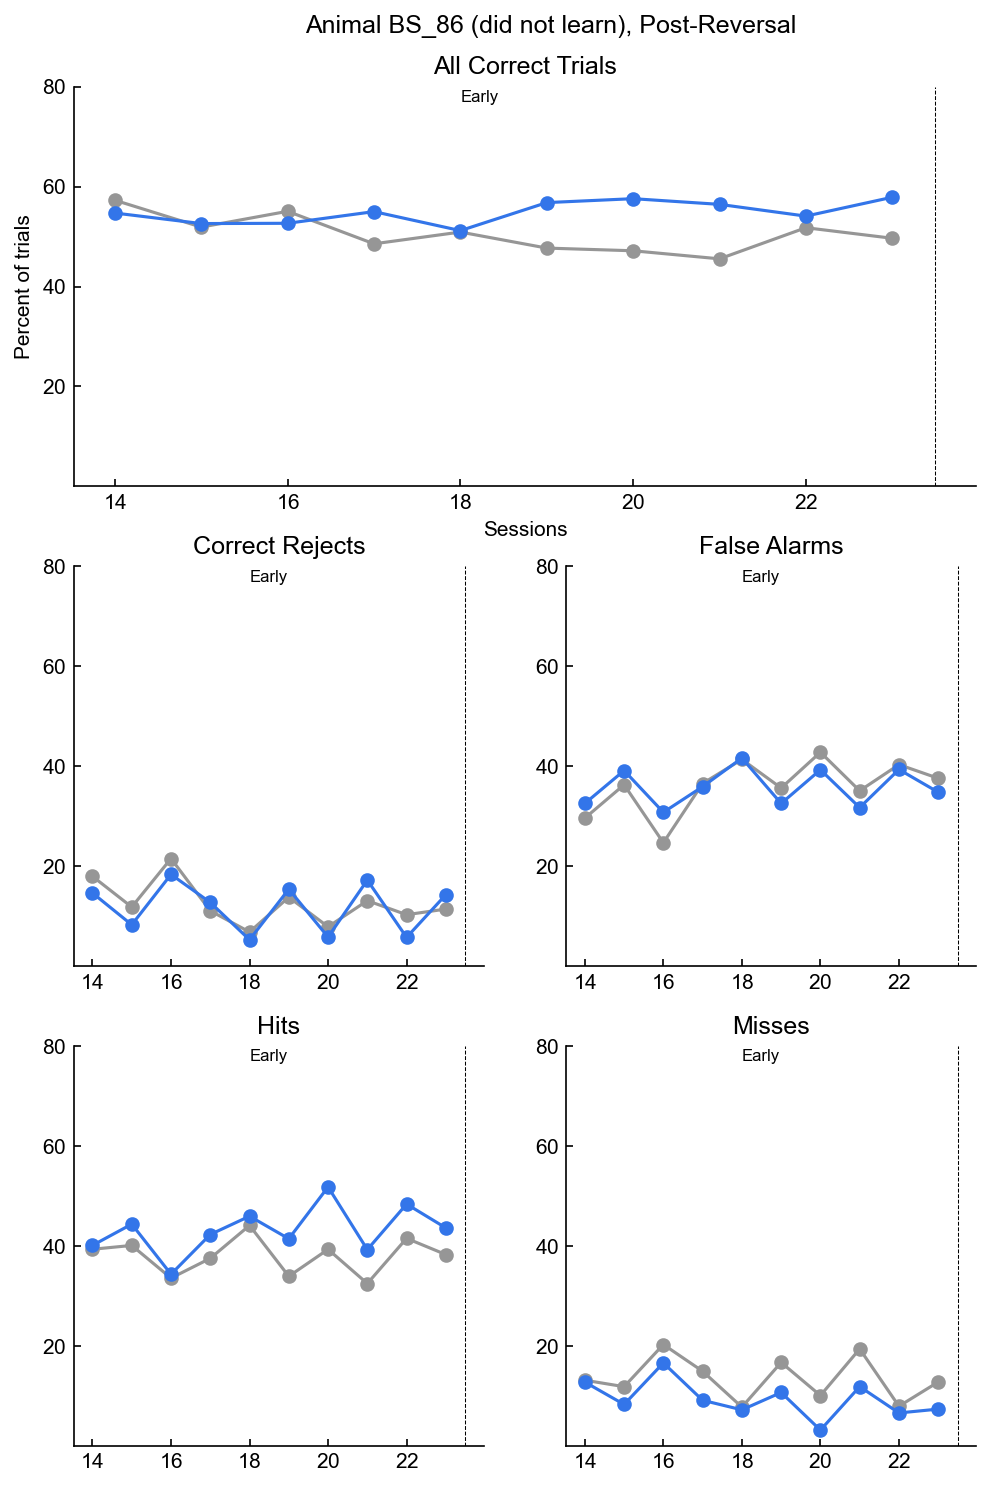

<Figure size 900x600 with 0 Axes>

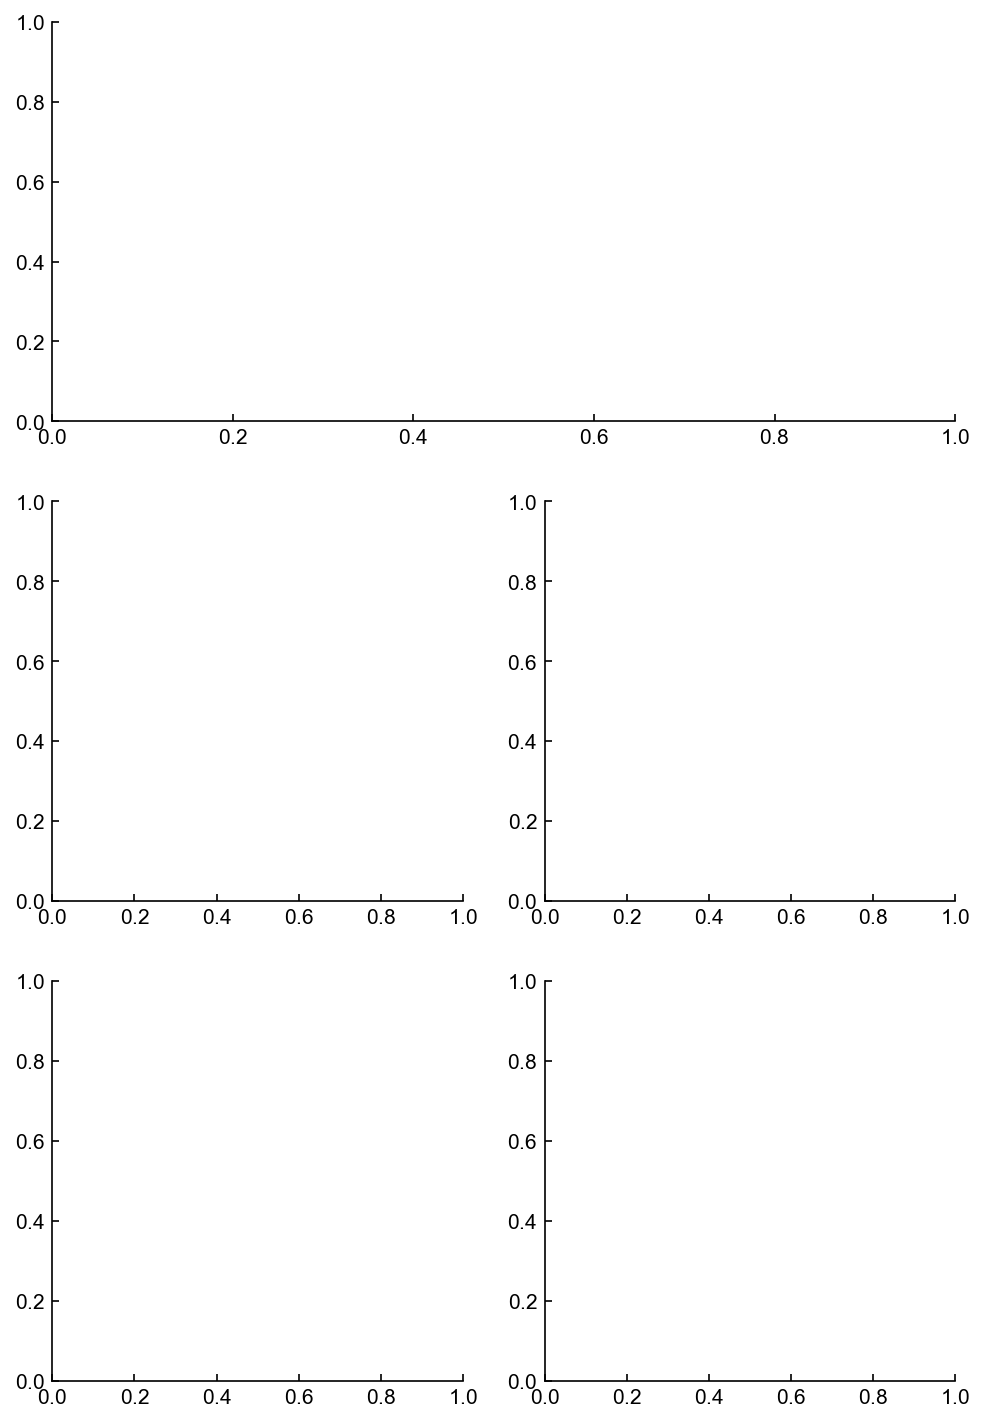

<Figure size 900x600 with 0 Axes>

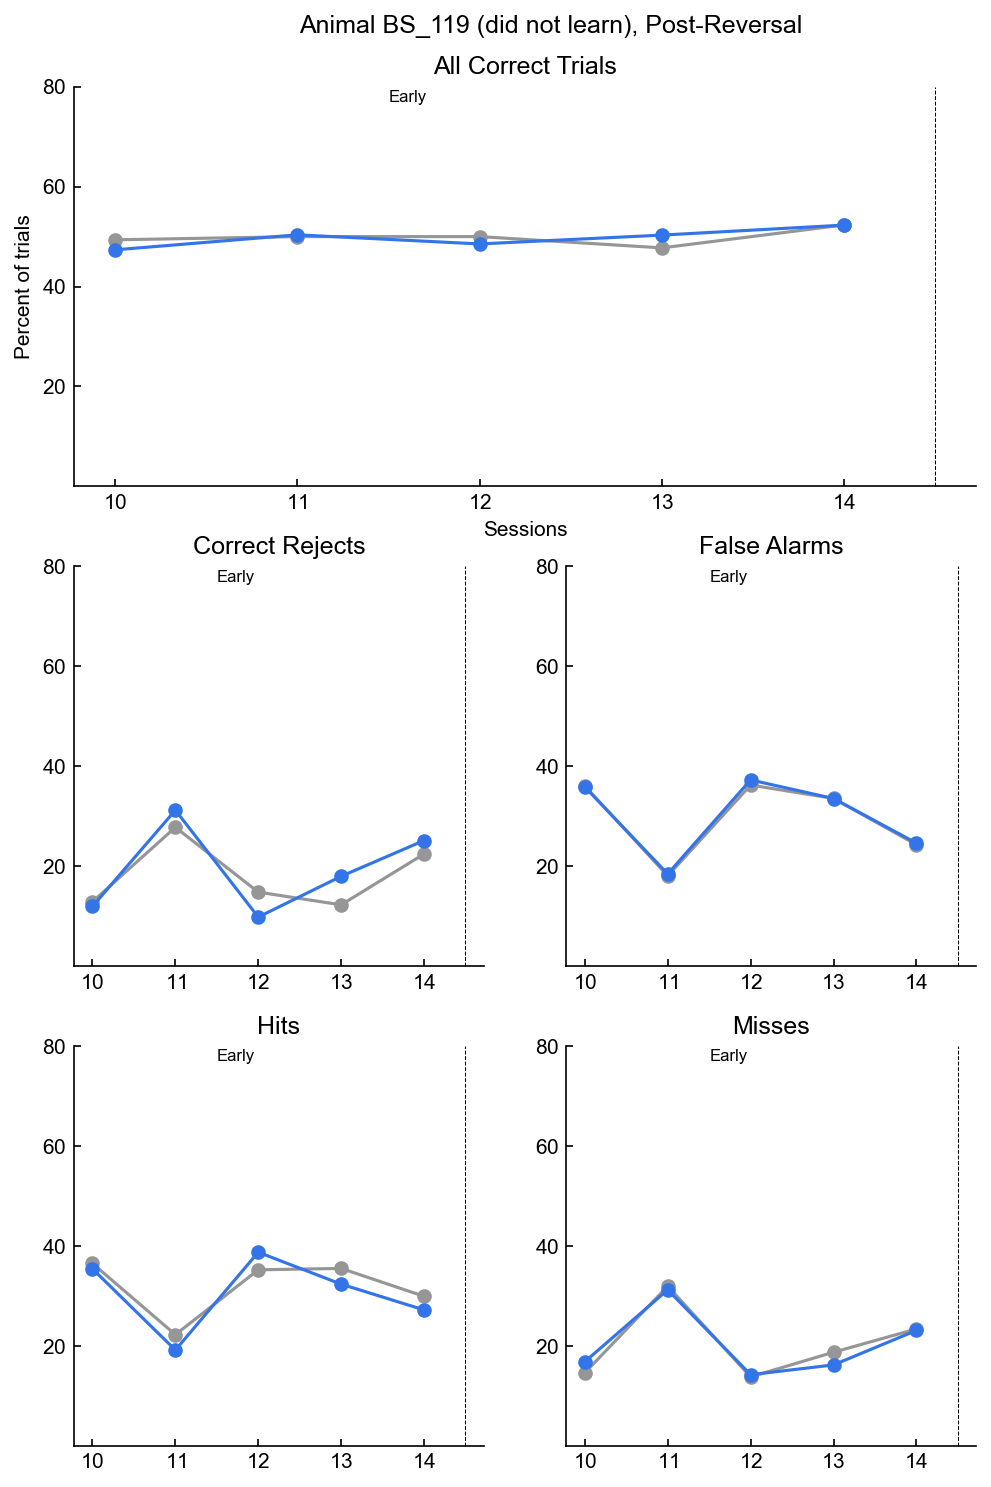

<Figure size 900x600 with 0 Axes>

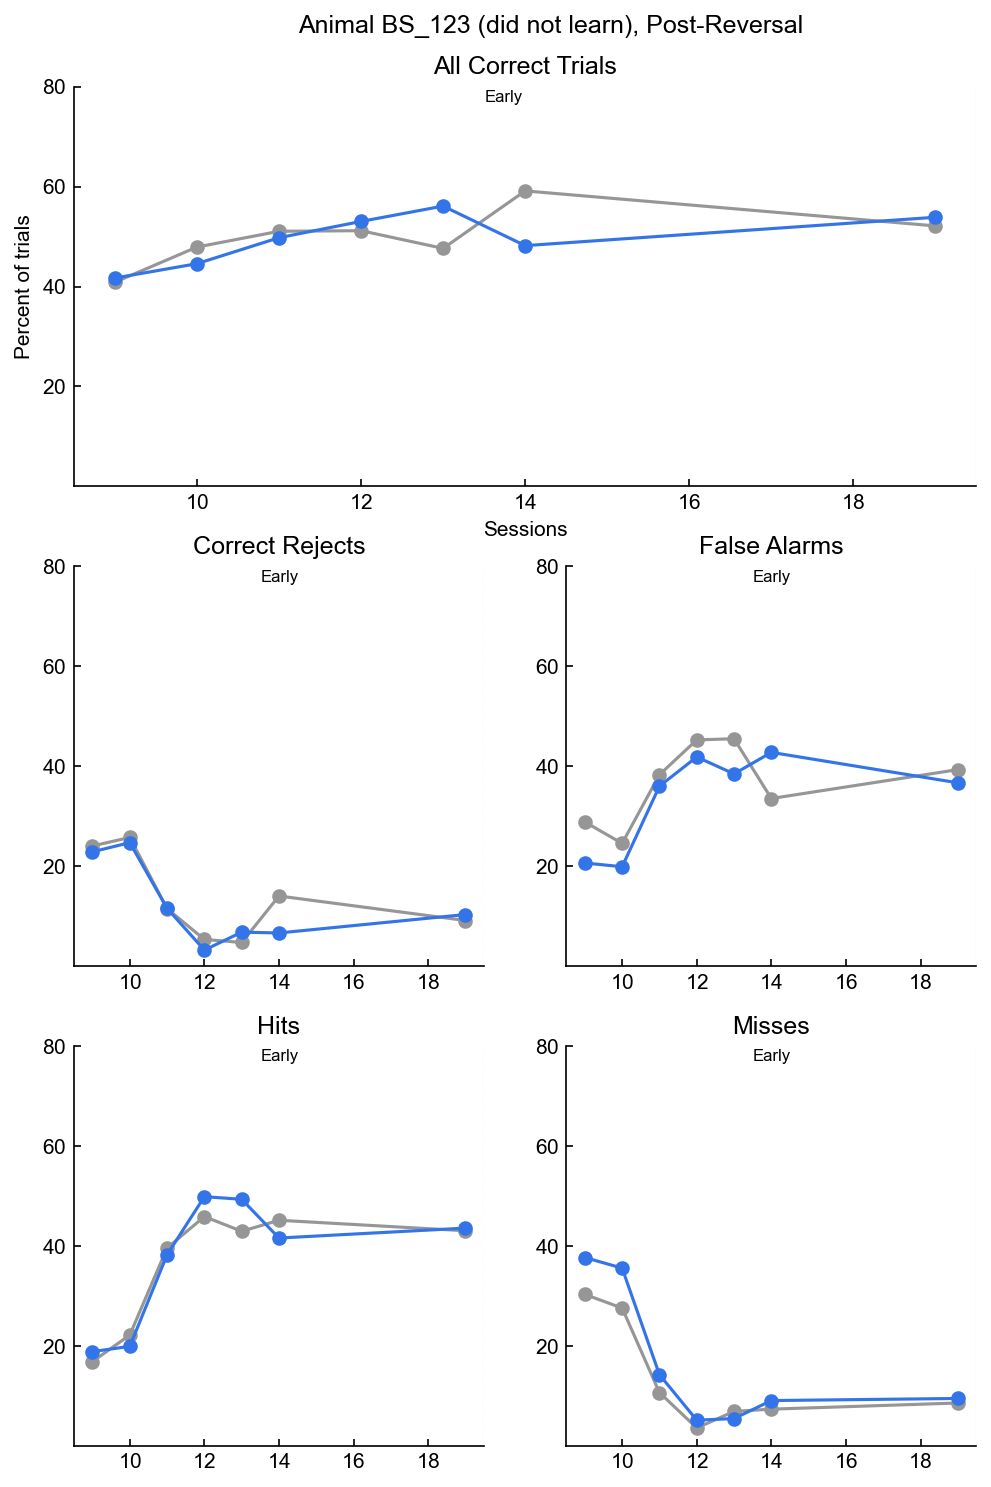

<Figure size 900x600 with 0 Axes>

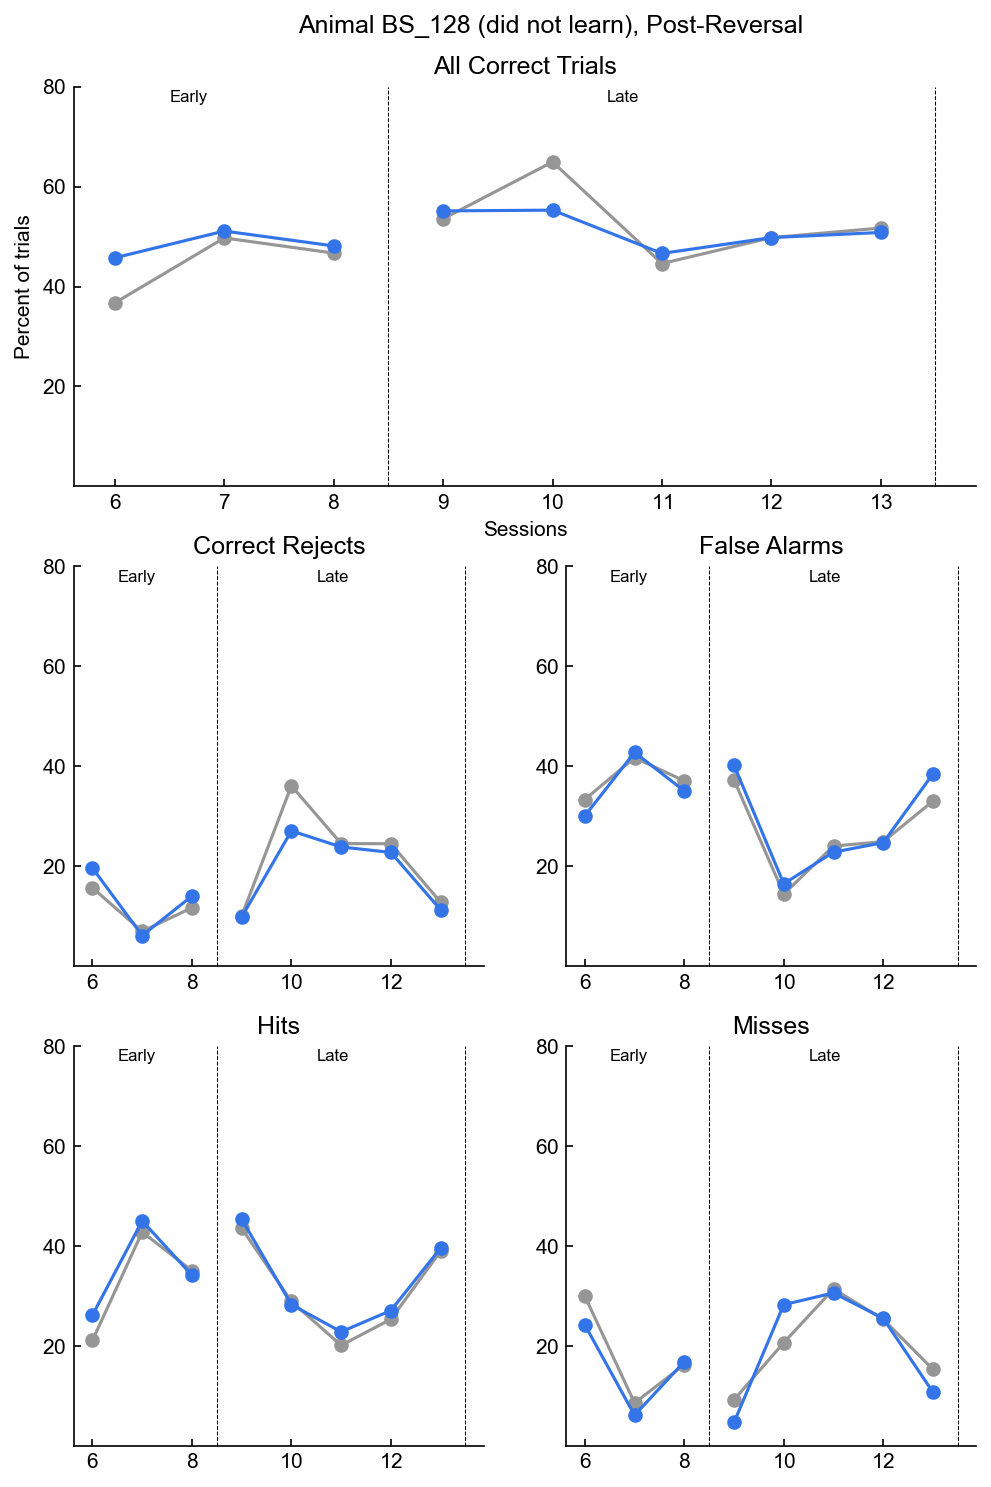

<Figure size 900x600 with 0 Axes>

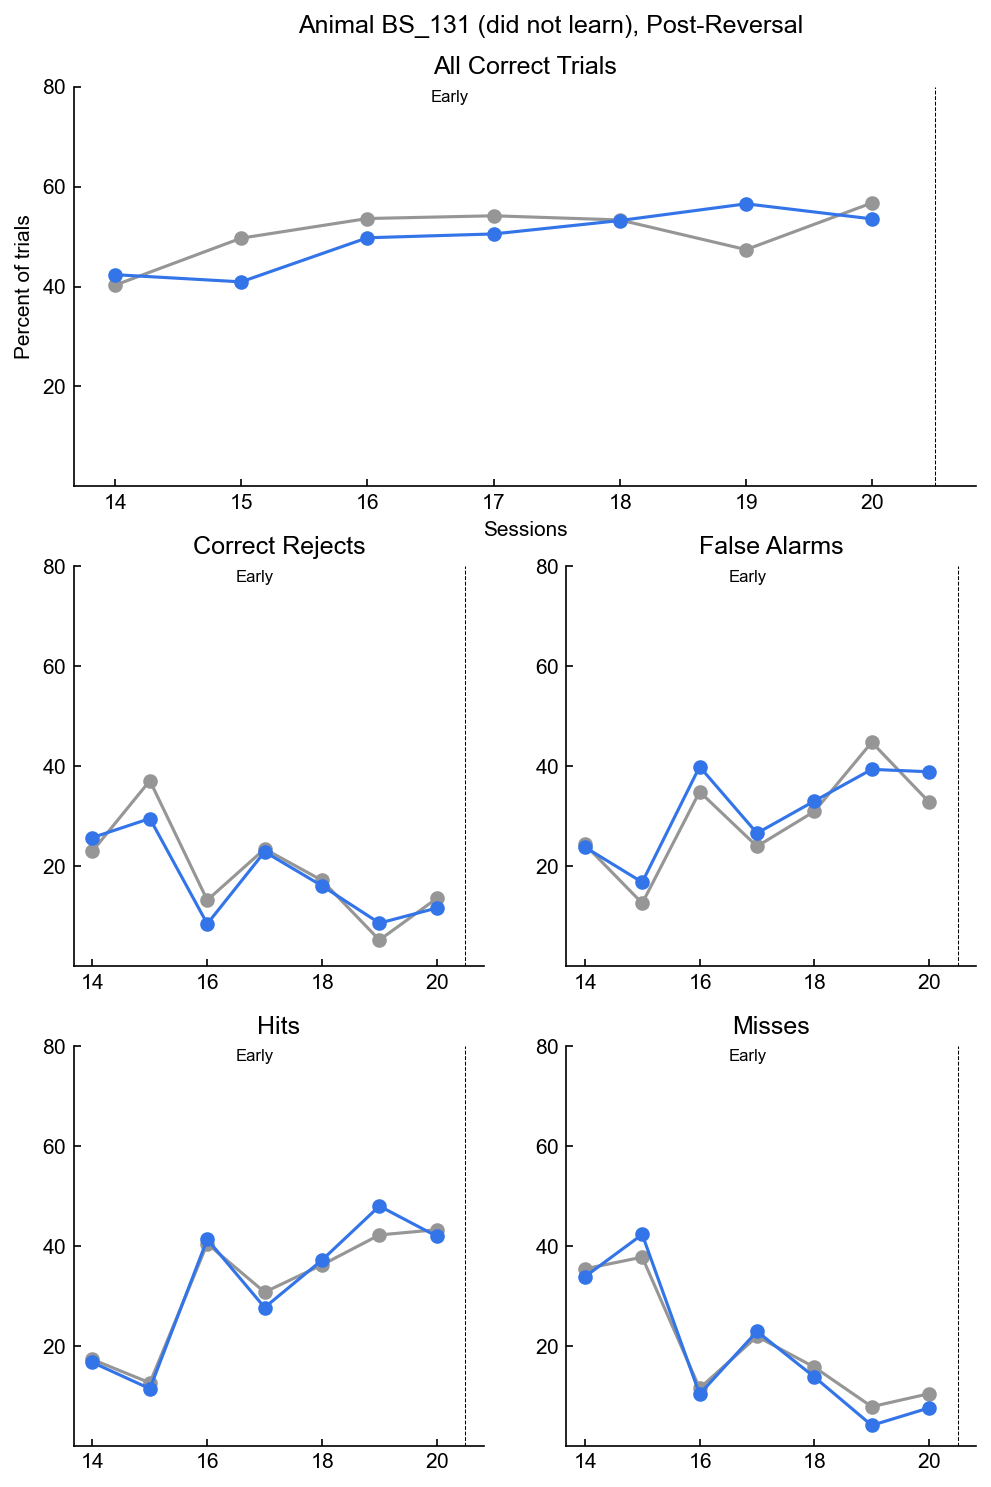

<Figure size 900x600 with 0 Axes>

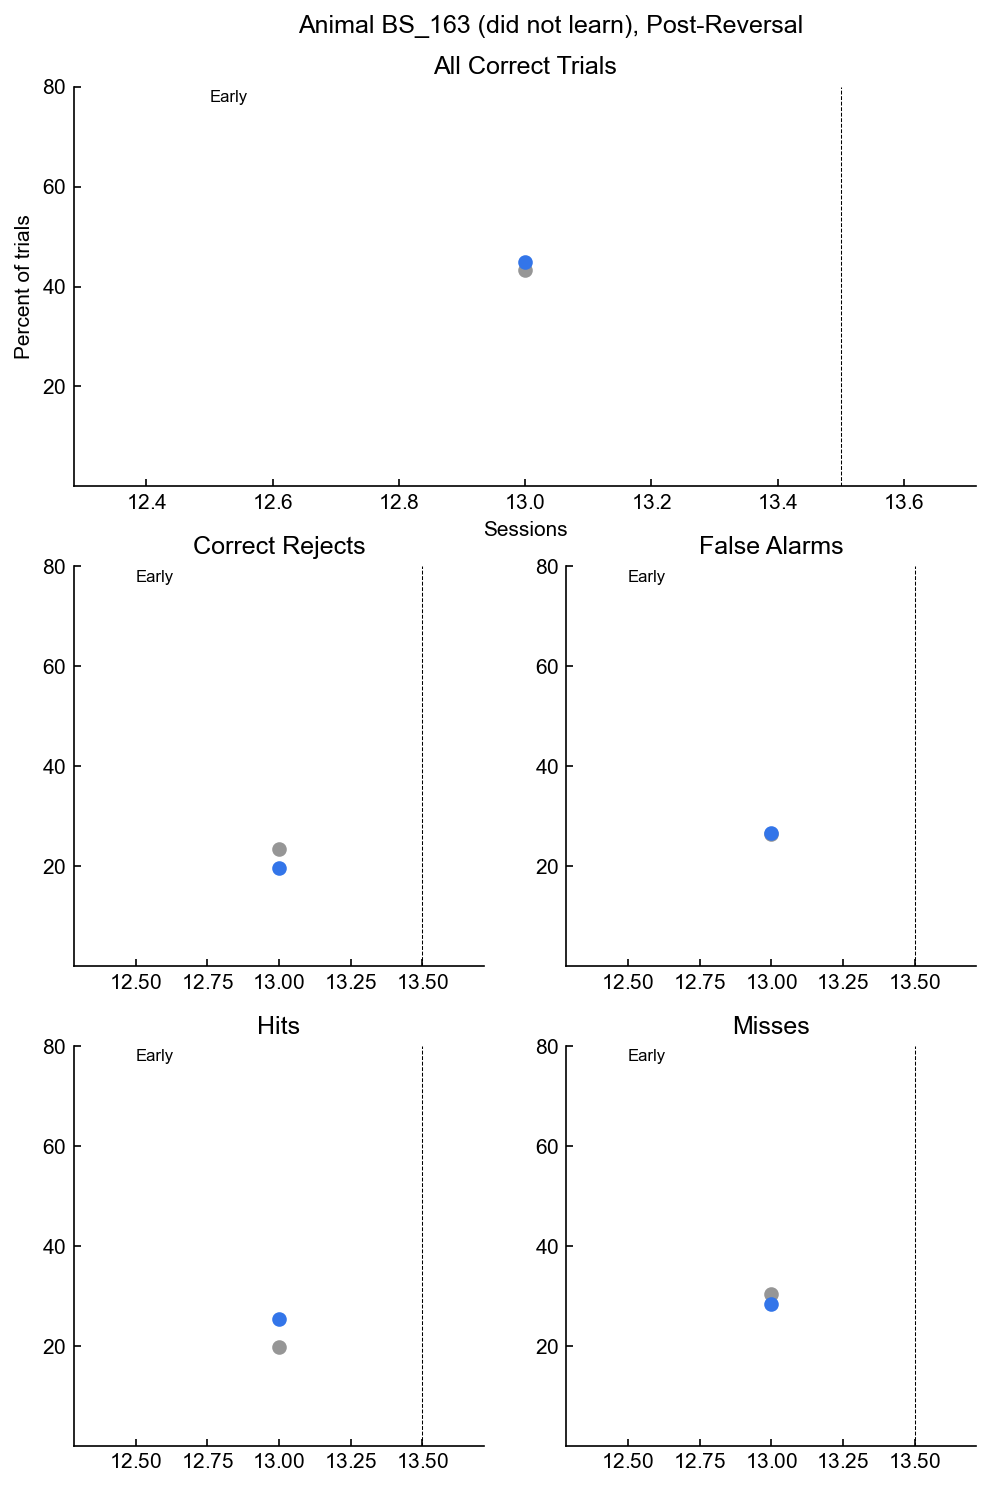

<Figure size 900x600 with 0 Axes>

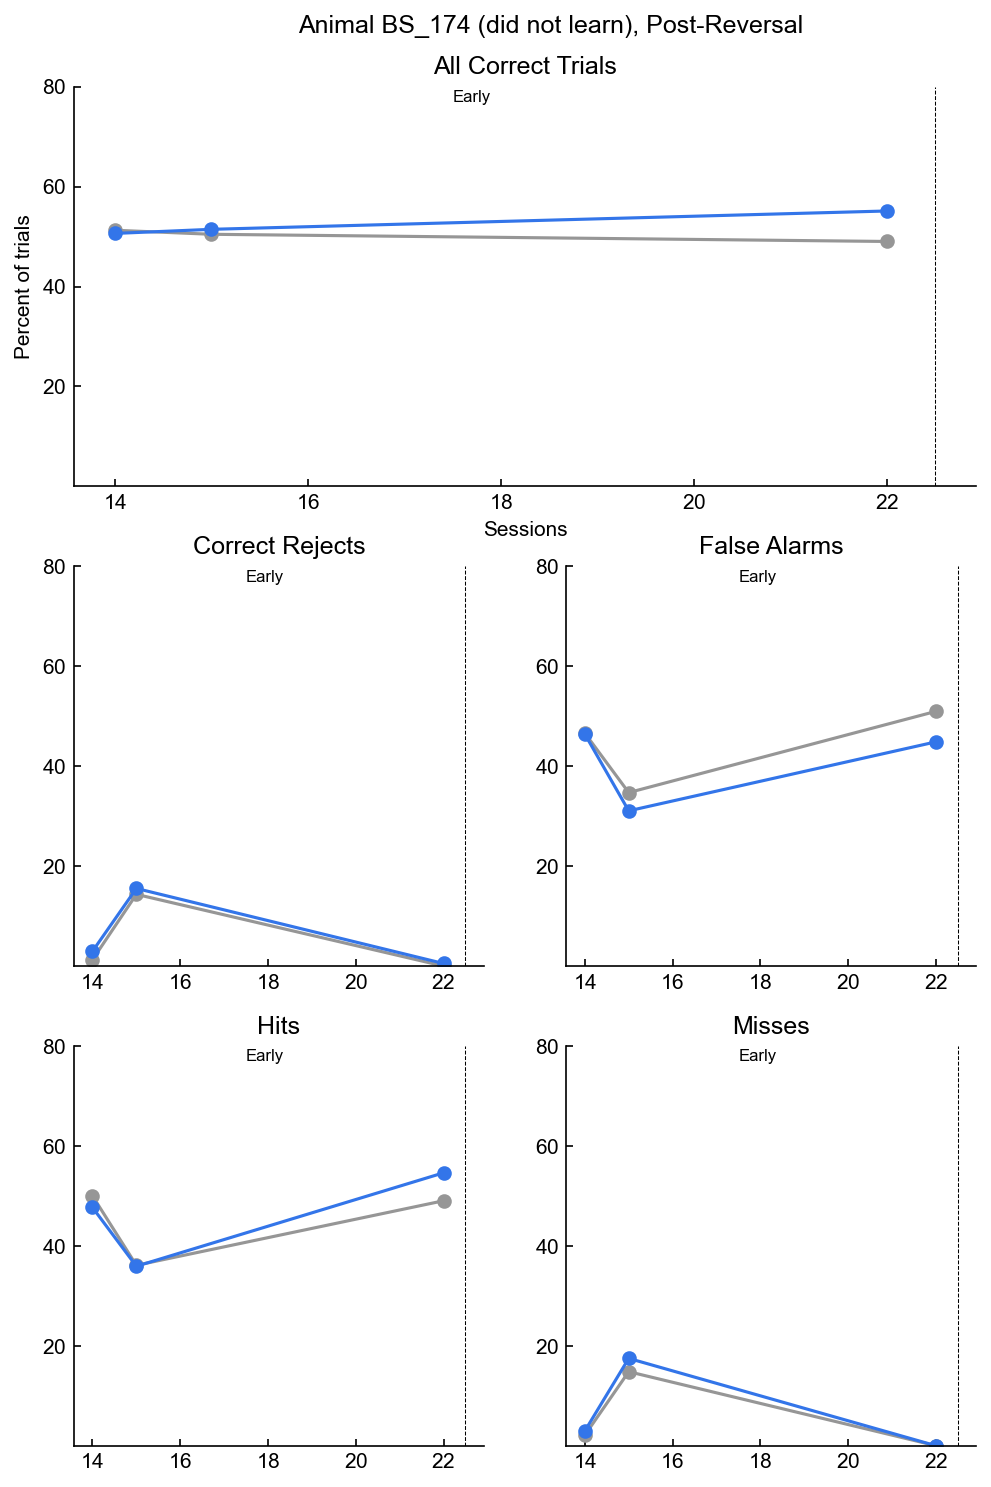

<Figure size 900x600 with 0 Axes>

In [520]:
animal = 'BS_92'

for animal in didnotlearnopsinanimals:
    plot_behavData_across_sessions(animal)


AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

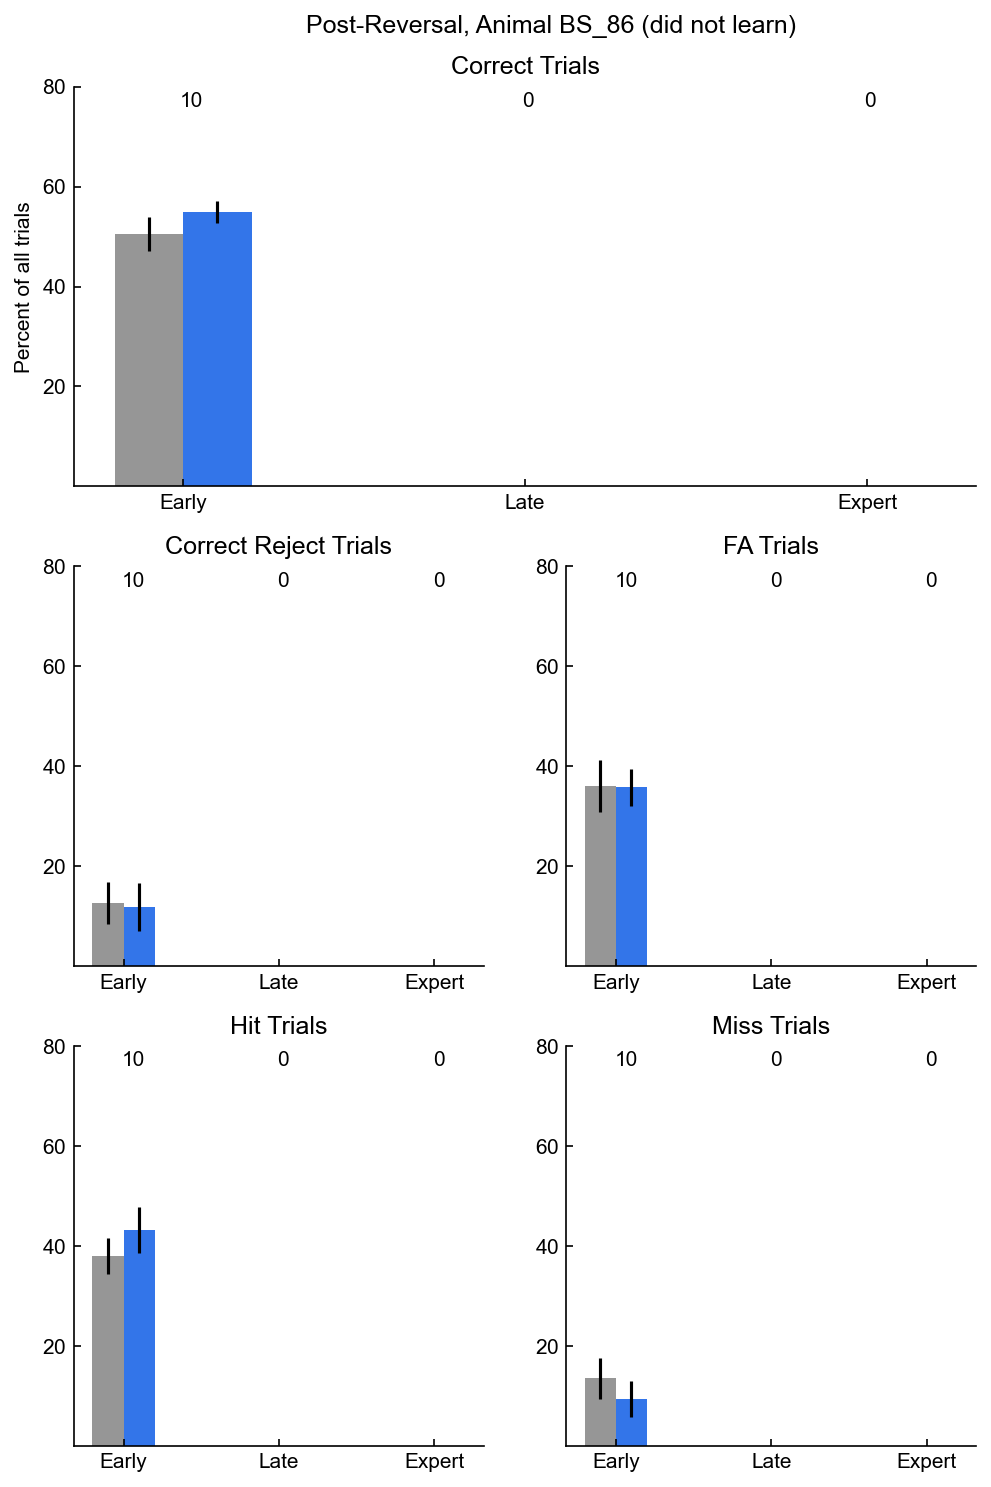

In [309]:
for animalidx,animal in enumerate(animals):
    plot_behavior_arrays(animal)

In [384]:
correct_postData_means = np.multiply(((animals[animal].postS_early_array_laserOFF_means[0], animals[animal].postS_early_array_laserON_means[0]),
                 (animals[animal].postS_late_array_laserOFF_means[0], animals[animal].postS_late_array_laserON_means[0]), 
                 (animals[animal].postS_expert_array_laserOFF_means[0], animals[animal].postS_expert_array_laserON_means[0])),100)
correct_postData_stds = np.multiply(((animals[animal].postS_early_array_laserOFF_stds[0], animals[animal].postS_early_array_laserON_stds[0]),
                 (animals[animal].postS_late_array_laserOFF_stds[0], animals[animal].postS_late_array_laserON_stds[0]), 
                 (animals[animal].postS_expert_array_laserOFF_stds[0], animals[animal].postS_expert_array_laserON_stds[0])),100)
    
    # CR data
CR_postData_means = np.multiply(((animals[animal].postS_early_array_laserOFF_means[1], animals[animal].postS_early_array_laserON_means[1]),
                 (animals[animal].postS_late_array_laserOFF_means[1], animals[animal].postS_late_array_laserON_means[1]), 
                 (animals[animal].postS_expert_array_laserOFF_means[1], animals[animal].postS_expert_array_laserON_means[1])),100)
CR_postData_stds = np.multiply(((animals[animal].postS_early_array_laserOFF_stds[1], animals[animal].postS_early_array_laserON_stds[1]),
                 (animals[animal].postS_late_array_laserOFF_stds[1], animals[animal].postS_late_array_laserON_stds[1]), 
                 (animals[animal].postS_expert_array_laserOFF_stds[1], animals[animal].postS_expert_array_laserON_stds[1])),100)

In [385]:
len(correct_postData_means)

3

In [386]:
len(CR_postData_means)

3

In [423]:
print(y_means)

NameError: name 'y_means' is not defined